# Lung Cancer Classification using Computerized Tomography (CT) Data


## Índicie
1. [Business Understanding](#business)
2. [Data Understanding](#data-understanding)
3. [Data Preparation](#data-preparation)
4. [Modeling](#modeling)
5. [Evaluation](#evaluation)
6. [Deployment & Ethics](#deployment)



##  1. Business Understanding

O cancro do pulmão continua entre as principais causas de mortalidade a nível mundial. O diagnóstico precoce aumenta significativamente a sobrevivência, mas a leitura manual de tomografias computorizadas (CT) é um processo exigente, demorado e sujeito a variações entre radiologistas. Este projeto procura desenvolver um classificador capaz de avaliar a probabilidade de malignidade de nódulos pulmonares com base em imagens CT, funcionando como uma ferramenta de apoio à decisão clínica. A ideia central é compreender se um pipeline de ciência de dados consegue identificar padrões relevantes nos nódulos — como textura, forma e intensidade — que ajudem no despiste de casos suspeitos e reforcem a consistência dos diagnósticos.


O trabalho segue a metodologia CRISP-DM, uma abordagem iterativa amplamente utilizada em ciência de dados. Esta metodologia organiza o desenvolvimento em seis fases: compreender o problema (Business Understanding), explorar e conhecer os dados (Data Understanding), preparar e transformar os dados para análise (Data Preparation), construir e treinar modelos (Modeling), avaliar o desempenho e validade das soluções (Evaluation) e, por fim, refletir sobre a aplicabilidade, limitações e aspetos éticos (Deployment). Nesta primeira versão do notebook, o foco encontra-se nas três primeiras fases.


Os dados utilizados provêm do conjunto LIDC-IDRI, um repositório público amplamente usado em investigação médica, composto por tomografias torácicas anotadas por radiologistas experientes. Cada paciente inclui imagens no formato DICOM e anotações detalhadas sobre a localização e características dos nódulos pulmonares, incluindo avaliações de malignidade. A maioria dos casos foi avaliada por quatro radiologistas, embora existam alguns exemplos com um número diferente de avaliadores. Este dataset foi escolhido por ser de acesso aberto, bem documentado e por permitir a extração de features tanto radiômicas como profundas (através de redes neuronais), o que o torna adequado para tarefas de classificação.
Ao longo do projeto, serão implementadas diferentes estratégias de pré-processamento, extração de features e modelação, que serão posteriormente comparadas de forma sistemática. O objetivo é identificar a abordagem que melhor se adequa ao problema, equilibrando desempenho, robustez e interpretabilidade.


O desempenho dos modelos será avaliado através de várias métricas complementares: accuracy (proporção de previsões corretas), precision (fiabilidade das classificações positivas), recall (capacidade de identificar corretamente os casos malignos), F1-score (equilíbrio entre precisão e sensibilidade) e AUC-ROC (capacidade global de discriminação entre classes). Estas métricas permitem avaliar o modelo de forma abrangente, considerando tanto a eficácia estatística como a relevância clínica dos resultados.


### Imports

Para realizar este trabalho foi necessário recorrer a diversas bibliotecas de Python, responsáveis pela manipulação e visualização de dados, processamento de imagens médicas, extração de features e construção dos modelos de machine learning. A célula abaixo reúne todas as importações utilizadas ao longo do projeto, devidamente organizadas por finalidade.

In [1]:
## Manipulação e análise de dados
import pandas as pd
import numpy as np
import csv
import os
import sys

In [2]:
## Processamento e visualização de imagens médicas
import pylidc as pl
import SimpleITK as sitk
import pyvista as pv
pv.set_jupyter_backend('trame')
from skimage import measure
from skimage.draw import polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/envs/liacd/lib/python3.10/site-packages/pylidc/__init__.py:27: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as _pr


In [3]:
## Machine Learning e pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [4]:
## Extração de features radiômicas
from radiomics import featureextractor

In [5]:
# utilitarios e funções 
import contextlib
import warnings
import logging

@contextlib.contextmanager
def silence_all_output():
    """Temporarily silence stdout, stderr, warnings, and radiomics logs."""
    radiomics_loggers = {
        name: logging.getLogger(name).level
        for name in logging.root.manager.loggerDict
        if name.startswith("radiomics")
    }

    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                for name in radiomics_loggers:
                    logging.getLogger(name).setLevel(logging.CRITICAL)

                try:
                    yield
                finally:
                    # restore logging levels
                    for name, level in radiomics_loggers.items():
                        logging.getLogger(name).setLevel(level)


## 2. Data Understanding

Nesta fase do projeto pretende-se compreender em profundidade o conjunto de dados LIDC-IDRI, explorando a sua estrutura, qualidade e consistência antes de qualquer transformação ou treino de modelos. O objetivo é identificar o tipo de informação disponível, o formato dos ficheiros, o significado de cada variável e a relação entre as diferentes fontes de dados (anotações radiológicas e diagnósticos clínicos).

Esta etapa é essencial para garantir que o processo de modelação se baseia em dados fiáveis e devidamente interpretados. Além disso, permite detetar possíveis problemas de qualidade ,como valores em falta, colunas redundantes, classes desbalanceadas ou incoerências entre anotações (que deverão ser tratados na fase seguinte Data Preparation).

O dataset LIDC-IDRI (Lung Image Database Consortium and Image Database Resource Initiative) contém tomografias torácicas de 1 010 pacientes, acompanhadas por anotações realizadas por radiologistas experientes. As anotações classificam as lesões em três categorias: nódulo ≥ 3 mm, nódulo < 3 mm e não-nódulo ≥ 3 mm. Apenas os nódulos com diâmetro igual ou superior a 3 mm foram caracterizados detalhadamente e são utilizados neste projeto.

Nesta secção serão analisados os ficheiros auxiliares disponibilizados com o dataset , nomeadamente os ficheiros (`lidc-idri-nodule-counts-6-23-2015.xlsx`) e (`tcia-diagnosis-data-2012-04-20.xls`) , e criado um Data Dictionary para cada um, de forma a compreender a função e relevância de cada coluna. Posteriormente, será realizada uma exploração inicial dos dados, avaliando a distribuição das observações e a existência de valores ausentes ou inconsistentes.

## 2.1 Estrutura dos Dados

### Data Dictionary

Para compreender melhor a estrutura dos ficheiros disponibilizados com o dataset, foram construídos Data Dictionaries que descrevem o conteúdo e o papel de cada coluna dos dois ficheiros principais associados ao LIDC-IDRI:


#### Dataset: `lidc-idri-nodule-counts-6-23-2015.xlsx`
- Que resume o número de nódulos identificados por paciente;


| Nome da Coluna | Tipo | Descrição | Valores Possíveis / Exemplo | Notas |
|----------------|------|------------|------------------------------|-------|
| **Patient_ID** | `string` | Identificador único do paciente. | `LIDC-001` | Pode repetir (paciente com vários TACs). |
| **Number of Nodules** | `int` | Número total de lesões que receberam uma marcação de “nódulo < 3 mm” ou “nódulo ≥ 3 mm” de pelo menos um dos quatro radiologistas do LIDC. | 0, 1, 2, ... | 0 = sem nódulos. |
| **Nodules ≥3mm** | `int` | Número total de lesões que receberam uma marcação de “nódulo ≥ 3 mm” de pelo menos um dos quatro radiologistas do LIDC (independentemente da forma como os outros radiologistas marcaram a lesão). | 0, 1, 2, ... | — |
| **Nodules <3mm** | `int` | Número total de lesões que receberam uma marcação de “nódulo < 3 mm” de pelo menos um dos quatro radiologistas do LIDC (sem que nenhum radiologista tenha atribuído à lesão uma marcação de “nódulo ≥ 3 mm”). | 0, 1, 2, ... | — |
| **Unnamed: 4** | — | Coluna sem informação. | — | Removida por não conter dados relevantes. |
| **Unnamed: 5** | — | Coluna explicativa. | — | Removida por não conter dados relevantes. |




#### Dataset: `tcia-diagnosis-data-2012-04-20.xls`
- Que contém informação clínica e diagnóstica sobre os pacientes e nódulos.


| Nome da Coluna | Tipo | Descrição | Valores Possíveis / Exemplo | Notas |
|----------------|------|------------|------------------------------|-------|
| **Patient_ID** | `string` | Identificador único do paciente. | `LIDC-001` | — |
| **Patient Diagnosis** | `int` | Diagnóstico do paciente. | 1 = Benigno, 2 = Maligno Primário | Valores 0 (Desconhecido) e 3 (Metastático) foram removidos do dataset. |
| **Patient Diagnosis Method** | `string` | Método de diagnóstico. | `"Histology"`, `"Clinical"` | — |
| **Primary tumor site for metastatic disease** | `string` | Local de origem do tumor metastático. | `"Lung"`, `"Breast"`, ... | Normalmente vazio; apenas preenchido para casos metastáticos (removidos do dataset). |
| **Nodule 1 Diagnosis** | `int` | Diagnóstico do nódulo 1. | -1 = Desconhecido, 1 = Benigno, 2 = Maligno Primário, 3 = Metastático | Valores NaN convertidos para -1. |
| **Nodule 1 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 1. | `"Histology"`, `"Clinical"` | — |
| **Nodule 2 Diagnosis** | `int` | Diagnóstico do nódulo 2. | -1, 1, 2, 3 | Valores NaN convertidos para -1. |
| **Nodule 2 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 2. | `"Histology"`, `"Clinical"` | — |
| **Nodule 3 Diagnosis** | `int` | Diagnóstico do nódulo 3. | -1, 1, 2, 3 | Removida: quase sempre vazia / NaN, sem dados relevantes. |
| **Nodule 3 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 3. | `"Histology"`, `"Clinical"` | Removida: quase sempre vazia / NaN, sem dados relevantes. |
| **Nodule 4 Diagnosis** | `int` | Diagnóstico do nódulo 4. | -1, 1, 2, 3 | Removida: sempre vazia / NaN, sem dados relevantes. |
| **Nodule 4 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 4. | `"Histology"`, `"Clinical"` | Removida: sempre vazia / NaN, sem dados relevantes. |
| **Nodule 5 Diagnosis** | `int` | Diagnóstico do nódulo 5. | -1, 1, 2, 3 | Removida: sempre vazia / NaN, sem dados relevantes. |
| **Nodule 5 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 5. | `"Histology"`, `"Clinical"` | Removida: sempre vazia / NaN, sem dados relevantes. |

##  2.2 Exploração Inicial dos Ficheiros
Depois de compreender a estrutura e o significado das variáveis através dos Data Dictionaries, passa-se agora à exploração prática dos ficheiros originais para confirmar a sua consistência e qualidade. Nesta etapa, os dados são carregados e analisados de forma a verificar a integridade e correspondência das informações descritas anteriormente.

- contagem de nódulos por paciente, criando o DataFrame (`nodules`) para análise.

In [6]:
nodules = pd.read_excel('lidc-idri-nodule-counts-6-23-2015.xlsx')

- Mostra o nome das colunas do dataset, permitindo confirmar se correspondem às variáveis descritas no Data Dictionary.

In [7]:
nodules.columns

Index(['TCIA Patent ID', 'Total Number of Nodules* ',
       'Number of Nodules >=3mm**', 'Number of Nodules <3mm***', 'Unnamed: 4',
       'Unnamed: 5'],
      dtype='object')

- Exibe as primeiras linhas do dataset, permitindo uma visualização inicial da estrutura dos dados e dos valores registados.

In [8]:
nodules.head()

,TCIA Patent ID,Total Number of Nodules*,Number of Nodules >=3mm**,Number of Nodules <3mm***,Unnamed: 4,Unnamed: 5
0,LIDC-IDRI-0001,4,1,3,NaN,NaN
1,LIDC-IDRI-0002,12,1,11,NaN,*total number of lesions that received either ...
2,LIDC-IDRI-0003,4,4,0,NaN,"**total number of lesions that received a ""nod..."
3,LIDC-IDRI-0004,4,1,3,NaN,"***total number of lesions that received a ""no..."
4,LIDC-IDRI-0005,9,3,6,NaN,NaN


## 2.3 Distribuição dos nódulos

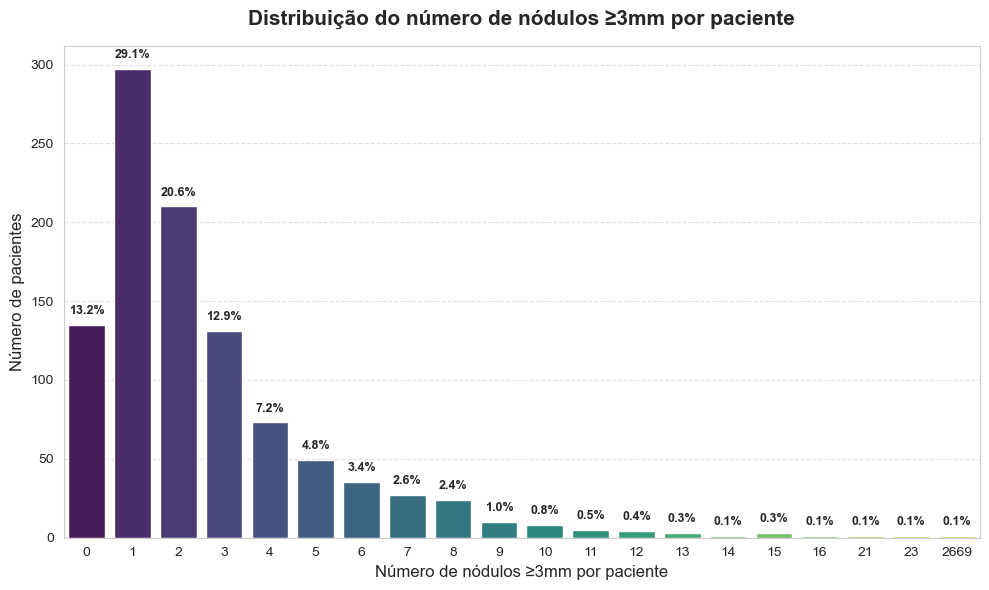

In [9]:
# Garante que a coluna é numérica
nodules["Number of Nodules >=3mm**"] = pd.to_numeric(nodules["Number of Nodules >=3mm**"], errors='coerce')

# Conta quantos pacientes têm 0, 1, 2, ... nódulos
count_by_nodules = nodules["Number of Nodules >=3mm**"].value_counts().sort_index()

# Calcula percentagens
percentages = (count_by_nodules / count_by_nodules.sum() * 100).round(1)

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

bars = sns.barplot(
    x=count_by_nodules.index,
    y=count_by_nodules.values,
    palette="viridis"
)

# Adiciona rótulos com percentagem em cima das barras
for i, (val, pct) in enumerate(zip(count_by_nodules.values, percentages)):
    if val > 0:  # só mostra rótulo se existir paciente nesse valor
        bars.text(i, val + 5, f"{pct}%", ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title("Distribuição do número de nódulos ≥3mm por paciente", fontsize=15, weight='bold', pad=15)
plt.xlabel("Número de nódulos ≥3mm por paciente", fontsize=12)
plt.ylabel("Número de pacientes", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


- O gráfico mostra que a maioria dos pacientes apresenta apenas um a três nódulos relevantes (≥ 3 mm), enquanto existe uma minoria de casos com um número muito superior de lesões. Esta distribuição assimétrica evidencia a predominância de casos simples e a presença de outliers clínicos  (aspetos que deverão ser considerados na preparação e modelação dos dados).

## 2.4 Conclusões

Concluída a exploração dos ficheiros e a análise da distribuição dos nódulos, inicia-se agora a fase de Data Preparation, onde serão tratadas colunas irrelevantes, valores em falta e efetuada a integração com a informação de diagnóstico. O objetivo é obter um conjunto de dados limpo e coerente, pronto para a extração de features e a construção dos modelos de classificação.

## 3. Data Preparation 

texto intrudotorio falta por ... 

### 3.1  Número de nódulos por paciente.

- Verifica a existência de valores ausentes em cada coluna, permitindo identificar possíveis lacunas a corrigir na limpeza dos dados.

In [10]:
nodules.isna().sum()

TCIA Patent ID                  1
Total Number of Nodules*        0
Number of Nodules >=3mm**       0
Number of Nodules <3mm***       0
Unnamed: 4                   1019
Unnamed: 5                   1016
dtype: int64

- Como as colunas Unnamed: 4 e Unnamed: 5 não contêm informação relevante, podem ser removidas sem impacto na análise.

In [11]:
nodules = nodules.iloc[:, :-2]

### 3.2 Aproveitamos para renomear o nome das colunas

- Aproveitamos para simplificar e padronizar os nomes das colunas, facilitando o acesso e a leitura dos dados nas próximas etapas.

In [12]:
nodules.columns = ['Patient_ID', 'Number of Nodules', 'Nodules >=3mm', 
                         'Nodules <3mm']

- Após renomear as colunas e remover as irrelevantes, verifica-se se existe alguma linha com valores em falta. Para isso, são filtradas apenas as observações que contêm pelo menos um valor NaN, permitindo identificar eventuais registos incompletos.

In [13]:
nan_rows = nodules[nodules.isnull().any(axis=1)]
nan_rows.head()

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
1018,NaN,7371,2669,4702


- A última linha apresenta um NaN na coluna Patient_ID e valores muito elevados nas restantes colunas, correspondendo a um somatório global dos nódulos de todos os pacientes. Como não representa um caso real, esta linha é removida do dataset.

In [14]:
nodules = nodules.drop(nodules.index[-1])

-  De seguida, confirmamos se a última linha foi corretamente removida do dataset.

In [15]:
nodules.tail()

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
1013,LIDC-IDRI-1008,7,6,1
1014,LIDC-IDRI-1009,2,1,1
1015,LIDC-IDRI-1010,10,1,9
1016,LIDC-IDRI-1011,4,4,0
1017,LIDC-IDRI-1012,1,1,0


### 3.3  Últimas verificações

- Verifica o número de pacientes únicos no dataset, garantindo que não existem identificadores duplicados após a limpeza.

In [16]:
nodules['Patient_ID'].nunique()

1010

- Como o número de pacientes únicos é inferior ao total de registos, verifica-se a existência de identificadores repetidos. Nesta etapa, listam-se os pacientes duplicados para analisar possíveis repetições nos dados.

In [17]:
nodules[nodules['Patient_ID'].duplicated(keep=False)]

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
131,LIDC-IDRI-0132,14,6,8
132,LIDC-IDRI-0132,12,8,4
151,LIDC-IDRI-0151,3,1,2
152,LIDC-IDRI-0151,7,1,6
315,LIDC-IDRI-0315,13,7,6
316,LIDC-IDRI-0315,8,5,3
333,LIDC-IDRI-0332,6,5,1
334,LIDC-IDRI-0332,3,2,1
357,LIDC-IDRI-0355,4,1,3
358,LIDC-IDRI-0355,3,2,1


- Verifica-se que as repetições não correspondem a duplicados reais, mas sim a pacientes que realizaram vários exames de tomografia (TAC). Este comportamento é confirmado ao analisar o dataset original. Assim, todas as entradas são mantidas, tratando cada TAC como um caso distinto associado ao mesmo paciente

In [18]:
multiple_entries = nodules[nodules['Patient_ID'].duplicated(keep=False)]['Patient_ID'].unique().tolist()
multiple_entries = [s[10:] for s in multiple_entries] # Retirar o 'LIDC-IDRI-' do nome
multiple_entries

['0132', '0151', '0315', '0332', '0355', '0365', '0442', '0484']

### 3.4  Diagnóstico dos pacientes

- Concluída a preparação do ficheiro de nódulos, procede-se agora à importação do segundo dataset que contem os diagnósticos clínicos , que permitirá associar cada paciente ao respetivo resultado (benigno ou maligno).

In [19]:
diagnosis = pd.read_excel('tcia-diagnosis-data-2012-04-20.xls')

- Renomiamos as colunas para remover caracteres desnecessários e tornar os nomes mais descritivos, facilitando o acesso e a compreensão das variáveis.

In [20]:
diagnosis.columns = ['Patient_ID', 'Patient Diagnosis', 'Patient Diagnosis Method', 
                         'Primary tumor site for metastatic disease',
                         'Nodule 1 Diagnosis', 'Nodule 1 Diagnosis Method', 
                         'Nodule 2 Diagnosis', 'Nodule 2 Diagnosis Method', 
                         'Nodule 3 Diagnosis', 'Nodule 3 Diagnosis Method',
                         'Nodule 4 Diagnosis', 'Nodule 4 Diagnosis Method',
                         'Nodule 5 Diagnosis', 'Nodule 5 Diagnosis Method']
diagnosis

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method,Nodule 3 Diagnosis,Nodule 3 Diagnosis Method,Nodule 4 Diagnosis,Nodule 4 Diagnosis Method,Nodule 5 Diagnosis,Nodule 5 Diagnosis Method
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LIDC-IDRI-0088,3,0,Uterine Cancer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LIDC-IDRI-0090,2,3,NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LIDC-IDRI-0994,2,3,LUL Large cell CA,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,LIDC-IDRI-1002,2,2,non-small cell carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,LIDC-IDRI-1004,2,3,LUL NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,LIDC-IDRI-1010,0,0,lymphoma,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Verificamos a presença de valores ausentes nas diferentes colunas para avaliar a sua relevância e decidir se é necessário tratar ou remover alguma variável.

In [21]:
# numero de nan por coluna 
diagnosis.isna().sum()

Patient_ID                                     0
Patient Diagnosis                              0
Patient Diagnosis Method                       0
Primary tumor site for metastatic disease      0
Nodule 1 Diagnosis                            20
Nodule 1 Diagnosis Method                     20
Nodule 2 Diagnosis                           137
Nodule 2 Diagnosis Method                    137
Nodule 3 Diagnosis                           156
Nodule 3 Diagnosis Method                    156
Nodule 4 Diagnosis                           157
Nodule 4 Diagnosis Method                    157
Nodule 5 Diagnosis                           157
Nodule 5 Diagnosis Method                    157
dtype: int64

- Como o dataset tem 157 entradas, observa-se que as quatro últimas colunas nunca possuem valores válidos, encontrando-se totalmente vazias. Além disso, o único valor existente na coluna Nodule 3 Diagnosis corresponde a um erro de leitura, pelo que estas variáveis não têm utilidade para a análise.

In [22]:
diagnosis[~pd.isna(diagnosis['Nodule 3 Diagnosis'])]

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method,Nodule 3 Diagnosis,Nodule 3 Diagnosis Method,Nodule 4 Diagnosis,Nodule 4 Diagnosis Method,Nodule 5 Diagnosis,Nodule 5 Diagnosis Method
114,LIDC-IDRI-0285,3,3,melanoma,3.0,3.0,0.0,0.0,,,NaN,NaN,NaN,NaN


- Como as colunas correspondentes aos nódulos 3, 4 e 5 se encontram vazias, removem-se as seis últimas colunas do dataset, mantendo apenas a informação clinicamente relevante.

In [23]:
diagnosis = diagnosis.iloc[:, :-6]
diagnosis.head(3)

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN


- Verifica os tipos de dados de cada coluna, garantindo que estão corretamente definidos após a limpeza e remoção de variáveis desnecessárias.

In [24]:
diagnosis.dtypes

Patient_ID                                    object
Patient Diagnosis                              int64
Patient Diagnosis Method                       int64
Primary tumor site for metastatic disease     object
Nodule 1 Diagnosis                           float64
Nodule 1 Diagnosis Method                    float64
Nodule 2 Diagnosis                           float64
Nodule 2 Diagnosis Method                    float64
dtype: object

Observa-se que as colunas de identificação e métodos de diagnóstico estão no formato de texto, enquanto as colunas de diagnóstico numérico aparecem como float64 devido à presença de valores ausentes (NaN). Estes tipos de dados serão ajustados conforme necessário nas etapas seguintes.

- As colunas dos diagnósticos dos nódulos 1 e 2 representam classificações discretas, pelo que devem ser do tipo inteiro. Para convertermos uma coluna de floats em inteiros precisamos primeiro que não existam NaNs. Para isso, vamos primeiro converter todos os valores NaN em -1.

In [25]:
cols = diagnosis.columns[4:8]  # select the numeric columns explicitly
diagnosis[cols] = diagnosis[cols].apply(lambda x: x.fillna(-1).astype(int))
print(diagnosis.dtypes)
diagnosis.head(3)

Patient_ID                                   object
Patient Diagnosis                             int64
Patient Diagnosis Method                      int64
Primary tumor site for metastatic disease    object
Nodule 1 Diagnosis                            int64
Nodule 1 Diagnosis Method                     int64
Nodule 2 Diagnosis                            int64
Nodule 2 Diagnosis Method                     int64
dtype: object


,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3,4,-1,-1
1,LIDC-IDRI-0071,3,1,Head & Neck,1,1,-1,-1
2,LIDC-IDRI-0072,2,4,Lung Cancer,1,4,-1,-1


- Após substituir os valores NaN por -1, é verificamos quais os pacientes que apresentam esta marcação, confirmando assim os casos em que não existe(ou é desconhecido) diagnóstico registado para o nódulo 1.

In [26]:
diagnosis[diagnosis['Nodule 1 Diagnosis'] == -1]

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
120,LIDC-IDRI-0314,2,2,adenocarcinoma,-1,-1,-1,-1
121,LIDC-IDRI-0325,2,2,squamous cell carcinoma/non-small cell,-1,-1,-1,-1
126,LIDC-IDRI-0405,1,2,reactive mesothelial cells,-1,-1,-1,-1
127,LIDC-IDRI-0454,2,2,non-small cell carcinoma,-1,-1,-1,-1
130,LIDC-IDRI-0510,1,2,focal fibrosis,-1,-1,-1,-1
131,LIDC-IDRI-0522,2,2,Adenocarcinoma,-1,-1,-1,-1
132,LIDC-IDRI-0543,2,2,small cell carcinoma,-1,-1,-1,-1
134,LIDC-IDRI-0562,2,3,adenocarcinoma,-1,-1,-1,-1
136,LIDC-IDRI-0576,0,2,reactive mesothelial cells,-1,-1,-1,-1
139,LIDC-IDRI-0624,1,3,Histoplasmosis with necrotizing granulomas,-1,-1,-1,-1


Em suma, estes casos correspondem a pacientes diagnosticados com cancro pulmonar, mas sem informação detalhada sobre os seus nódulos.
- Se o modelo for treinado ao nível do nódulo, estes registos devem ser excluídos, pois não possuem label individual.

- Se o modelo for treinado ao nível do paciente, estes casos devem ser mantidos, garantindo apenas que o processo de agregação trata adequadamente a ausência de dados nos nódulos.

Após tratar os casos com informação incompleta, procede-se à seleção das classes de diagnóstico relevantes, mantendo apenas os dados que contribuem diretamente para o objetivo de classificação.

No ficheiro (`tcia-diagnosis-data-2012-04-20.xls`) existem duas informações particularmente relevantes para este estudo: Diagnóstico do Paciente e Diagnóstico do Nódulo.
Estas variáveis podem assumir os seguintes valores:
- Desconhecido
- Benigno
- Maligno (Cancro de Pulmão Primário)
- Maligno (Metastático)

Pacientes com diagnóstico desconhecido são excluídos, uma vez que não contribuem para o objetivo do modelo e apenas introduziriam ruído nos dados, comprometendo a qualidade do treino.
Da mesma forma, são também removidos os casos de cancro maligno metastático, cujo tumor tem origem noutro órgão. O propósito deste trabalho é distinguir cancro de pulmão primário de casos benignos, e incluir exemplos metastáticos poderia confundir o modelo, dado que as suas características visuais podem diferir significativamente das de um tumor primário.

- Filtramos então o dataset, removendo pacientes com diagnóstico desconhecido (0) e casos metastáticos (3), mantendo apenas os pacientes com diagnóstico benigno (1) ou maligno primário (2), que constituem o foco do estudo.

In [27]:
diagnosis = diagnosis[(diagnosis['Patient Diagnosis'] != 0) & (diagnosis['Patient Diagnosis'] != 3)]
diagnosis

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
2,LIDC-IDRI-0072,2,4,Lung Cancer,1,4,-1,-1
4,LIDC-IDRI-0090,2,3,NSCLC,2,3,-1,-1
12,LIDC-IDRI-0138,2,2,Lung Cancer,2,2,-1,-1
14,LIDC-IDRI-0149,1,1,chondrosarcoma,1,1,-1,-1
17,LIDC-IDRI-0162,1,1,gallbladder,1,1,-1,-1
...,...,...,...,...,...,...,...,...
150,LIDC-IDRI-0939,2,3,RUL Small cell,2,3,-1,-1
151,LIDC-IDRI-0965,2,3,Adenocarcinoma,-1,-1,-1,-1
152,LIDC-IDRI-0994,2,3,LUL Large cell CA,2,3,-1,-1
153,LIDC-IDRI-1002,2,2,non-small cell carcinoma,-1,-1,-1,-1


Foram removidas 78 entradas (157 → 79) correspondentes a diagnósticos desconhecidos ou metastáticos, resultando num conjunto de 79 pacientes válidos para a análise e modelação.

- Verificamos se, após a remoção dos pacientes metastáticos, ainda permanecem nódulos classificados como metastáticos (3) nas colunas individuais de diagnóstico.

In [28]:
diagnosis[diagnosis['Nodule 2 Diagnosis'] == 3]

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
27,LIDC-IDRI-0174,2,3,nonsmall cell lung cancer,2,3,3,4
58,LIDC-IDRI-0214,2,3,non small cell lung,2,3,3,4
128,LIDC-IDRI-0470,2,2,nonsmall cell lung cancer,2,2,3,4


Verifica-se que, embora o diagnóstico do paciente seja Maligno Primário (2), alguns nódulos individuais foram anotados como Metastáticos (3). Este tipo de inconsistência sugere erro de anotação no dataset original, uma vez que todos os nódulos associados a um paciente com cancro primário deveriam partilhar a mesma classificação.

Após a limpeza e filtragem dos dados clínicos, passa-se agora à preparação do segundo conjunto de dados — as anotações radiológicas obtidas a partir do dataset LIDC-IDRI. Estas anotações descrevem as características visuais dos nódulos pulmonares observados nas tomografias computorizadas.

### 3.5 Criação de um dataset com todas as anotações

- Nesta etapa, é gerado um novo dataset que agrega todas as anotações realizadas pelos radiologistas para cada nódulo identificado nas tomografias.
Através da biblioteca (`pylidc`), são extraídas informações detalhadas sobre cada nódulo, incluindo o grau de malignidade, características morfológicas (como textura, esfericidade e margens) e parâmetros técnicos do exame (espessura das fatias e resolução dos píxeis).
O objetivo é criar um ficheiro .csv estruturado, onde cada linha representa uma anotação de um nódulo específico, identificada por um código único (`NoduleID`), permitindo análises quantitativas e integração futura com os dados clínicos.

In [29]:
# Obtém todos os scans disponíveis
def gen_dataset():
    scans = pl.query(pl.Scan).all()
    
    if not scans:
        print("No scans found, verify if the path is correct.")
        exit(1)
    
    with open('data.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # cabeçalho
        writer.writerow([
            'NoduloID', 'Annotation ID', 'Num Annotations',
            'Malignancy', 'Calcification', 'Internal Structure',
            'Spiculation', 'Margin', 'Subtlety',
            'Lobulation', 'Texture', 'Sphericity',
            'Volume',
            'Slice Thickness (mm)', 'Pixel Resolution'
        ])
        
        for scan in scans:
    
            nodulos = scan.cluster_annotations()
            num_nodulos = len(nodulos)
    
            slice_thickness = scan.slice_thickness
            pixel_spacing = scan.pixel_spacing
            
            # Verifica se existem nódulos
            if num_nodulos == 0:
                writer.writerow([
                    scan.patient_id[-4:], 0,
                    None, None, None, 
                    None, None, None, 
                    None, None, None,
                    None,
                    slice_thickness, pixel_spacing
                ])
            else:
                for idx, nodulo in enumerate(nodulos):
                    
                    num_an = len(nodulo)
    
                    nod_id = scan.patient_id[-4:] + f"-{idx+1}"
    
                    an_id = 1
                    for anotacao in nodulo:
    
                        writer.writerow([
                            nod_id, an_id, num_an, 
                            anotacao.malignancy, anotacao.calcification, anotacao.internalStructure,
                            anotacao.spiculation, anotacao.margin, anotacao.subtlety, 
                            anotacao.lobulation, anotacao.texture, anotacao.sphericity,
                            anotacao.volume,
                            slice_thickness, pixel_spacing
                        ])
                        an_id += 1
    
    print("Finished generating .csv file.")

#Convertido em função para não correr sempre que se dá run a tudo do notebook
#gen_dataset()

- Após a geração do ficheiro com todas as anotações radiológicas, procede-se à sua leitura e organização. O objetivo é garantir que os registos estão ordenados por identificador de nódulo, facilitando consultas futuras e eventuais junções com outros datasets.

In [30]:
annotation_data = pd.read_csv('data.csv')
annotation_data = annotation_data.sort_values(by="NoduloID")
annotation_data = annotation_data.reset_index(drop=True)
annotation_data.to_csv('data.csv', index=False)
annotation_data.head()

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
0,0001-1,4,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125
1,0001-1,4,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125
2,0001-1,4,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125
3,0001-1,4,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125
4,0002-1,2,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641


- Filtram-se os casos em que o número de anotações é superior a 4, de modo a identificar possíveis inconsistências, uma vez que cada nódulo no dataset LIDC-IDRI deveria ter, no máximo, quatro anotações de radiologistas.

In [31]:
filtered = annotation_data[annotation_data['Num Annotations'] > 4]
filtered

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
490,0055-1,6,4.0,6.0,1.0,4.0,3.0,4.0,3.0,5.0,3.0,193.428040,2.5,0.703125
491,0055-1,6,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,205.169678,2.5,0.703125
492,0055-1,6,3.0,6.0,1.0,2.0,3.0,3.0,2.0,4.0,3.0,244.720459,2.5,0.703125
493,0055-1,6,2.0,6.0,1.0,1.0,5.0,3.0,3.0,5.0,3.0,1751.358032,2.5,0.703125
494,0055-1,6,4.0,6.0,1.0,2.0,3.0,4.0,3.0,4.0,4.0,292.304993,2.5,0.703125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6567,0942-1,7,3.0,6.0,1.0,3.0,5.0,5.0,4.0,5.0,5.0,2866.307831,1.0,0.742188
6568,0942-1,7,3.0,6.0,1.0,3.0,5.0,5.0,4.0,5.0,5.0,1169.438171,1.0,0.742188
6569,0942-1,7,4.0,6.0,1.0,3.0,1.0,5.0,2.0,3.0,5.0,3621.512604,1.0,0.742188
6570,0942-1,7,5.0,6.0,1.0,1.0,3.0,5.0,3.0,5.0,3.0,1413.736725,1.0,0.742188


- Foram identificados 81 registos com mais de quatro anotações por nódulo, o que sugere possíveis inconsistências no processo de anotação. Como o protocolo do LIDC-IDRI prevê no máximo quatro radiologistas por nódulo, será agora analisado quais os identificadores (`NoduloID`) que apresentam este problema, de forma a compreender melhor a origem destes casos.

In [32]:
wrong_nodule = filtered[filtered.columns[0]].unique()
print(f"Existem {len(wrong_nodule)} nodulos com anotações erradas")
wrong_nodule = [s[:4] for s in wrong_nodule.tolist()]
print(wrong_nodule)

Existem 14 nodulos com anotações erradas
['0055', '0092', '0137', '0204', '0252', '0332', '0340', '0366', '0404', '0608', '0815', '0863', '0865', '0942']


- Para investigar visualmente os nódulos com número excessivo de anotações, define-se uma função auxiliar que permite carregar o exame TAC correspondente a um paciente e visualizar as suas anotações.

- Esta função utiliza a biblioteca pylidc para aceder às máscaras tridimensionais desenhadas pelos radiologistas, possibilitando confirmar se as anotações correspondem ao mesmo nódulo ou se resultam de sobreposições incorretas durante o processo de clustering

In [33]:
def print_all_ann(id: str, idx: list):
    %matplotlib inline
    
    # Select scan by patient ID
    pid = "LIDC-IDRI-" + id
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
    
    if not scan:
        raise ValueError(f"No scan found for patient {pid}")
    
    anns = scan.annotations
    print(f"Found {len(anns)} annotations for patient {scan.patient_id}")
    
    for i, ann in enumerate(anns, 1):
        if (i in idx):
            ann.visualize_in_scan(False) 

- Começamos por analisar o paciente LIDC-IDRI-0366, um exemplo em que o número de anotações é elevado mas aparentemente consistente.
O objetivo é confirmar visualmente se as anotações se sobrepõem corretamente ao mesmo nódulo, garantindo que o agrupamento automático não gerou duplicações.

Found 8 annotations for patient LIDC-IDRI-0366


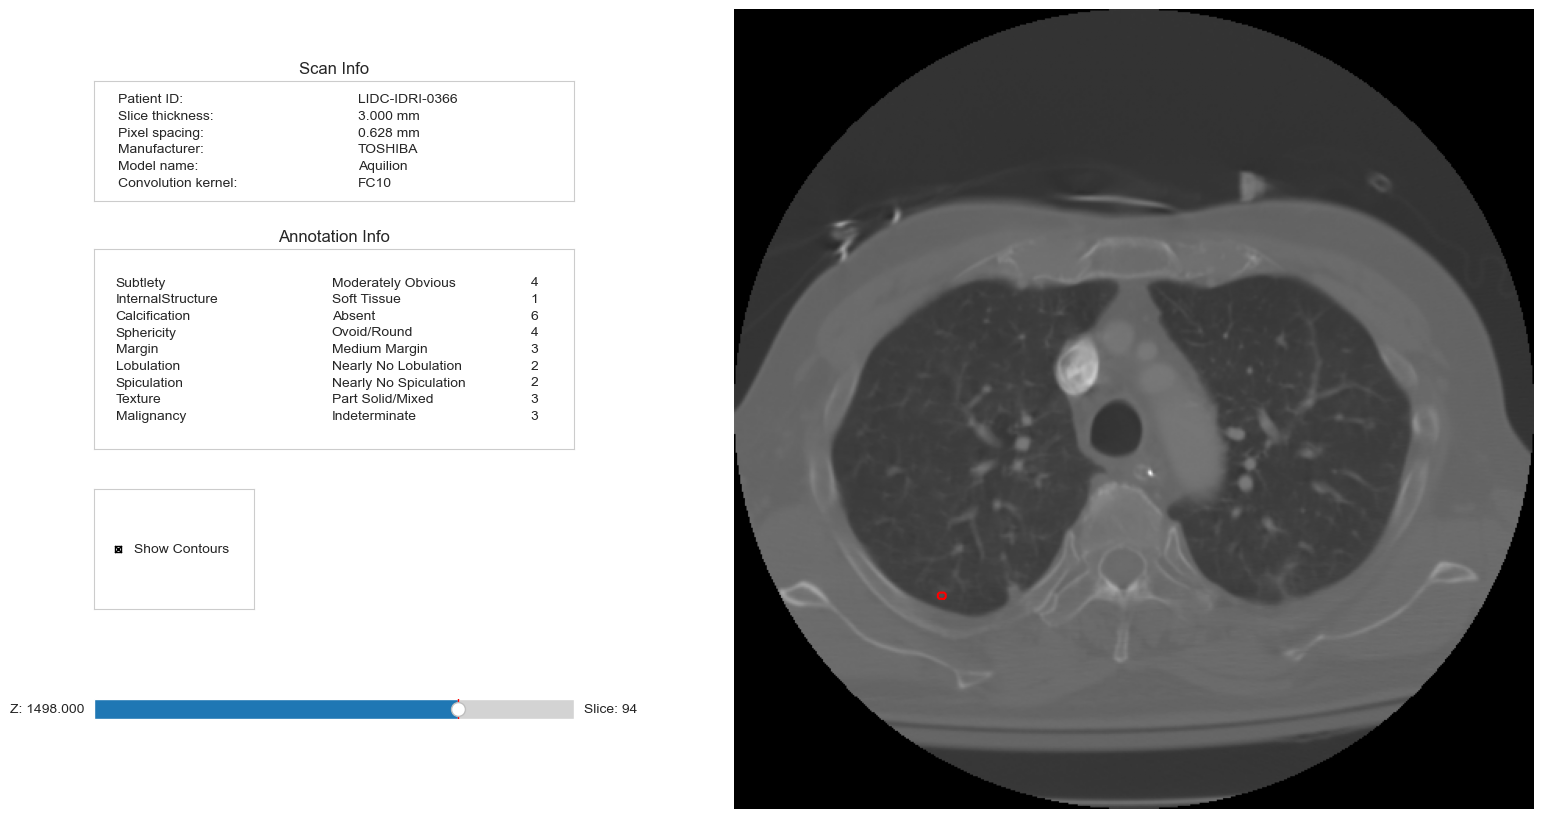

In [34]:
print_all_ann("0366", [2])

A visualização confirma que o nódulo está corretamente delimitado e que as diferentes anotações são coerentes entre si.
Neste caso, o agrupamento automático foi bem-sucedido, representando corretamente um único nódulo examinado por vários radiologistas.

- Em contraste, analisamos agora o paciente LIDC-IDRI-0340, outro caso com número elevado de anotações, para verificar se o agrupamento manteve a coerência espacial.

Found 8 annotations for patient LIDC-IDRI-0340


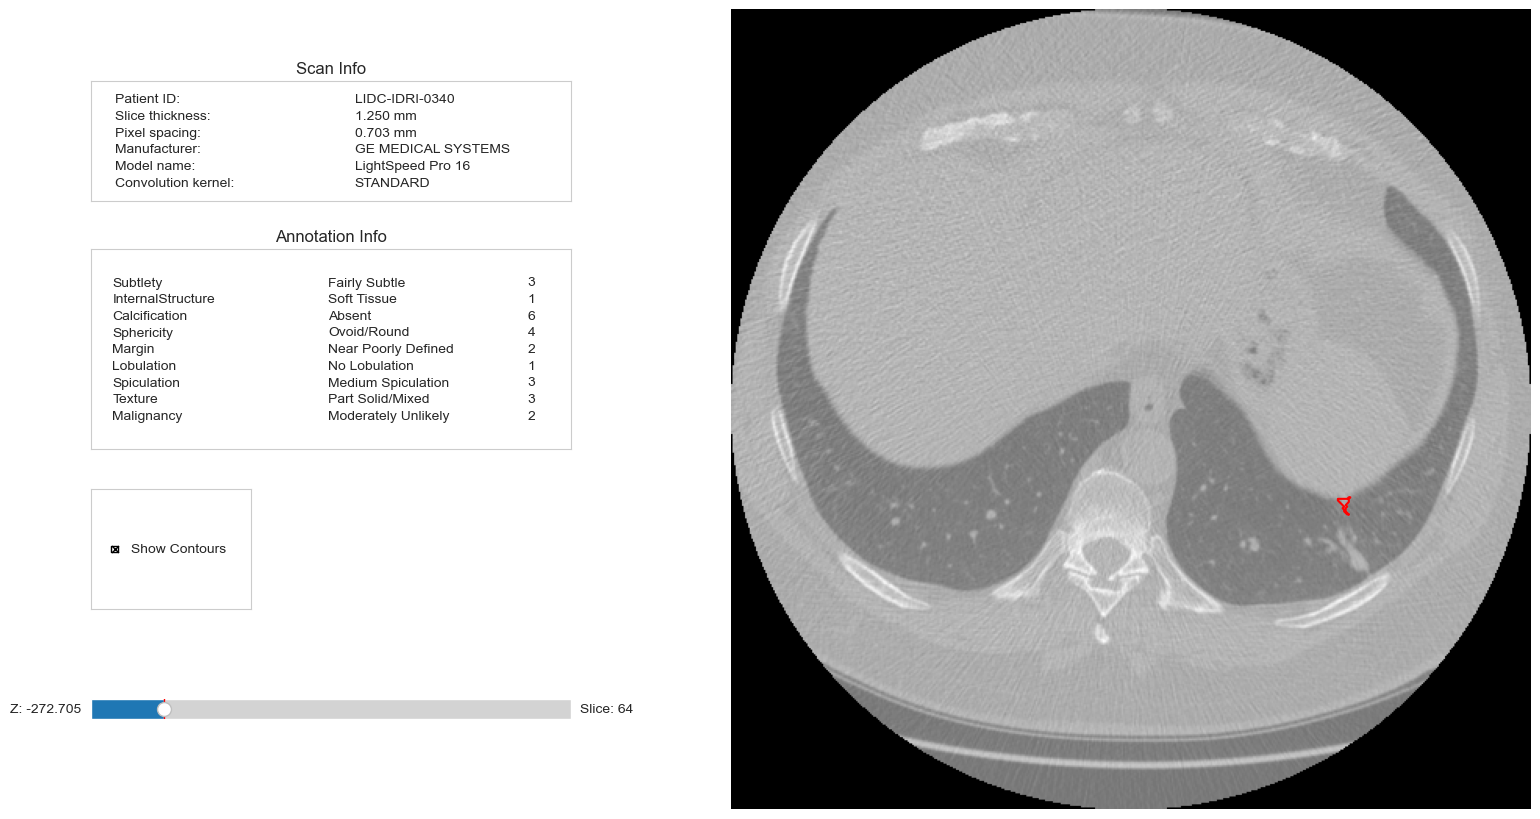

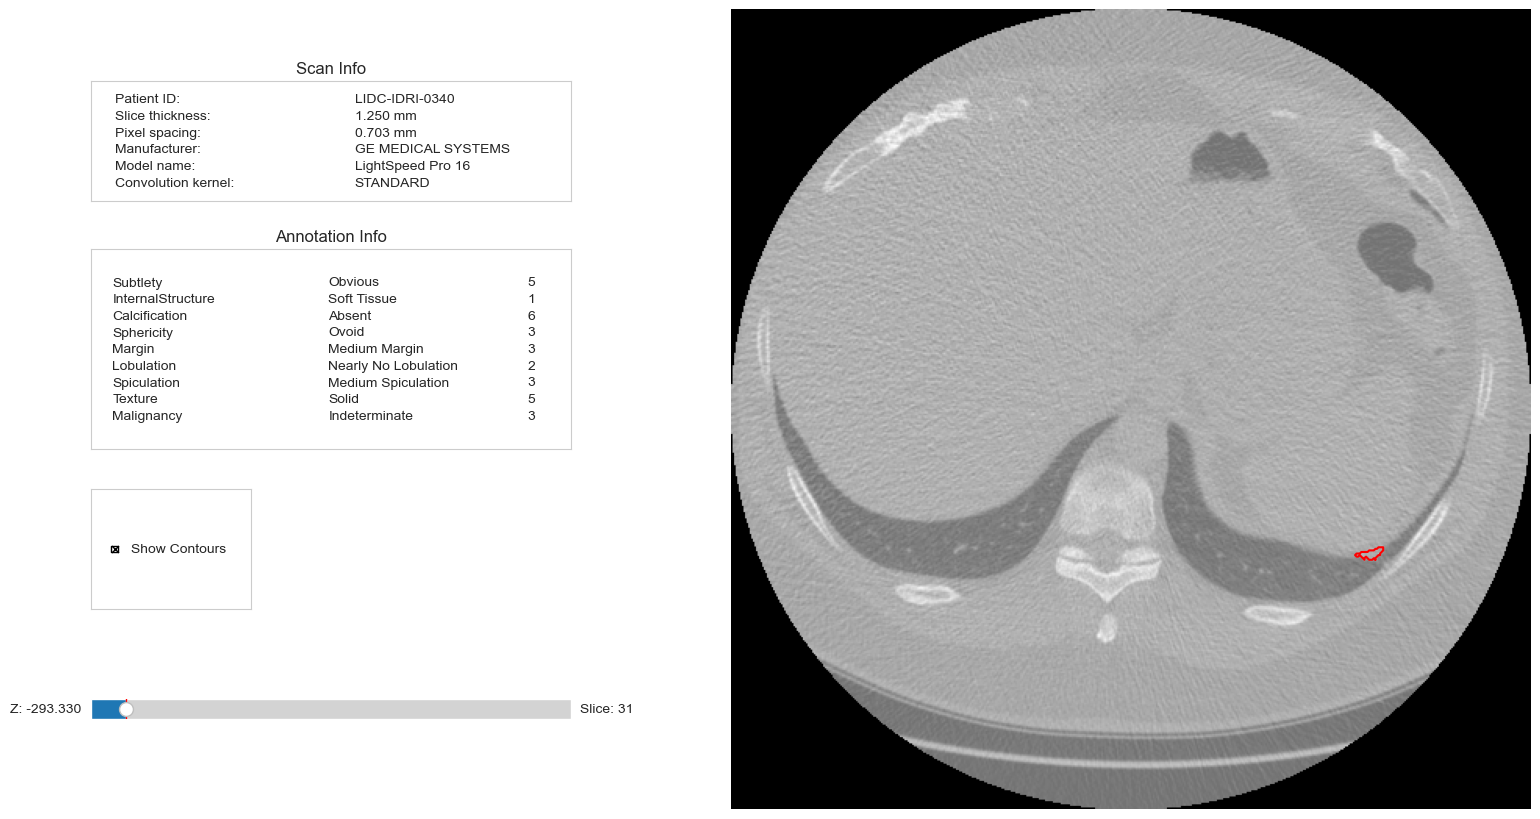

In [35]:
print_all_ann("0340", [7,8])

Como se observa nas imagens, as anotações encontram-se em regiões distintas do pulmão, representando nódulos diferentes.
Assim, conclui-se que este é um caso de erro de clustering, em que anotações independentes foram incorretamente associadas a um único nódulo.
Por esse motivo, este paciente deve ser removido do dataset final para evitar ruído e preservar a qualidade dos dados.

- Após a análise dos casos com anotações incorretas, é também importante verificar se existem pacientes sem qualquer anotação associada.
Estes exames não contêm informação sobre a localização ou existência de nódulos e, por isso, não contribuem para o treino do modelo.

In [36]:
filtered = annotation_data[annotation_data['Num Annotations'] == 0]
no_nodule = filtered[filtered.columns[0]].unique()
print(f"Existem {len(no_nodule)} pacientes sem anotações")
print(no_nodule)

Existem 135 pacientes sem anotações
['0028' '0032' '0062' '0071' '0100' '0143' '0174' '0189' '0197' '0205'
 '0214' '0218' '0224' '0225' '0226' '0239' '0253' '0261' '0279' '0293'
 '0295' '0306' '0307' '0316' '0322' '0327' '0330' '0331' '0333' '0336'
 '0342' '0349' '0361' '0364' '0382' '0383' '0389' '0391' '0401' '0410'
 '0417' '0418' '0422' '0425' '0428' '0441' '0446' '0455' '0465' '0472'
 '0482' '0506' '0511' '0512' '0513' '0514' '0519' '0528' '0531' '0536'
 '0540' '0544' '0548' '0561' '0564' '0573' '0589' '0600' '0603' '0612'
 '0616' '0622' '0623' '0627' '0632' '0646' '0653' '0665' '0667' '0668'
 '0679' '0683' '0685' '0689' '0690' '0691' '0710' '0711' '0716' '0718'
 '0731' '0737' '0738' '0745' '0746' '0755' '0760' '0764' '0774' '0784'
 '0804' '0808' '0839' '0853' '0862' '0876' '0877' '0878' '0881' '0885'
 '0887' '0889' '0891' '0897' '0900' '0901' '0903' '0918' '0927' '0930'
 '0931' '0934' '0937' '0948' '0952' '0954' '0960' '0964' '0967' '0970'
 '0975' '0979' '0988' '0992' '0995']


Verifica-se que não existem pacientes sem anotações — todos os exames possuem pelo menos uma marcação realizada por um ou mais radiologistas.
Isto confirma que o dataset se encontra completo em termos de anotações válidas, não havendo necessidade de eliminar casos adicionais nesta fase.

- Por fim, confirmámos que os pacientes sem nódulos correspondem aos casos sem anotações registadas.
O dataset de anotações encontra-se agora limpo e estruturado, contendo uma linha por anotação e as respetivas características extraídas de cada nódulo.

In [37]:
annotation_data.head(3)

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
0,0001-1,4,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.5,0.703125
1,0001-1,4,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.5,0.703125
2,0001-1,4,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.5,0.703125


- Cada registo representa uma anotação individual associada a um nódulo, incluindo atributos morfológicos e visuais avaliados pelos radiologistas (por exemplo, Malignancy, Spiculation, Margin, Texture).
Este dataset servirá de base para a integração com o diagnóstico clínico, permitindo associar as características dos nódulos às respetivas classes de benignidade ou malignidade.

### 3.6 Remoções do Dataset 

Nesta etapa são eliminados os registos que não contribuem para o processo de modelação.
São removidos: 

- Pacientes sem nódulos, uma vez que não fornecem informação relevante para a análise.

- Casos com mais de quatro anotações, identificados anteriormente como anotações incorretas (nódulos avaliados de forma inconsistente, parcialmente segmentados ou sobrepostos).

Mantêm-se, contudo, os pacientes com múltiplas entradas, pois correspondem a diferentes exames TAC do mesmo indivíduo, podendo ser tratados como observações válidas e independentes.

In [38]:
annotation_data = annotation_data[~annotation_data["NoduloID"].astype(str).str.startswith(tuple(f"{s}-" for s in wrong_nodule))]

Foram removidas 156 entradas correspondentes a pacientes com nódulos mal avaliados, garantindo que o dataset contém apenas anotações consistentes e clinicamente válidas.

- Em seguida, removem-se os pacientes sem nódulos, identificados anteriormente como casos sem anotações.
Estes registos não acrescentam informação útil ao processo de modelação e são, portanto, excluídos do dataset final.

In [39]:
annotation_data = annotation_data[~annotation_data["NoduloID"].astype(str).str.startswith(tuple(f"{s}" for s in no_nodule))]

Removemos corretamente os 135 pacientes sem nódulos.
Em teoria, o dataset deve agora conter cerca de 6700 = 6994-159-135  entradas válidas.

- Confirmamos o número total de pacientes com anotações incorretas para contabilizar o impacto das remoções realizadas.

In [40]:
len(wrong_nodule)

14

Assim, após remover os 135 pacientes sem nódulos e os 14 pacientes com anotações incorretas, o dataset deverá conter cerca de 861 pacientes distintos com nódulos válidos e anotados de forma consistente.

- Após a limpeza e remoção dos casos inválidos, apresentamos o dataset final de anotações, já filtrado e pronto para integração com o diagnóstico clínico.

In [41]:
annotation_data

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
0,0001-1,4,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125
1,0001-1,4,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125
2,0001-1,4,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125
3,0001-1,4,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125
4,0002-1,2,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6989,1011-4,1,2.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,92.315674,2.50,0.859375
6990,1012-1,4,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,258.504689,2.50,0.722656
6991,1012-1,4,2.0,6.0,1.0,2.0,4.0,4.0,2.0,3.0,4.0,125.857838,2.50,0.722656
6992,1012-1,4,2.0,6.0,1.0,1.0,3.0,4.0,1.0,5.0,4.0,167.636374,2.50,0.722656


O dataset encontra-se agora coeso e validado, contendo apenas nódulos corretamente anotados, com as respetivas características morfológicas e parâmetros de imagem.
Estes dados serão utilizados na próxima fase, dedicada à integração com o diagnóstico e preparação do dataset final de treino.

- Por fim, confirmamos o número de pacientes únicos que permanecem no dataset após as remoções.

In [42]:
df = annotation_data.copy()
df["base_id"] = annotation_data["NoduloID"].str.extract(r"^(\d+)-")

print(f"{df['base_id'].nunique()} pacientes diferentes.")

861 pacientes diferentes.


O resultado confirma o total de pacientes distintos com nódulos válidos e anotações consistentes, tal como tínhamos estimado anteriormente.

### 3.7 Merge dos Datasets

Para consolidar toda a informação relevante, procedemos à junção dos diferentes datasets utilizados no estudo:

- NoduleCountsByPatient (`lidc-idri-nodule-counts-6-23-2015.xlsx`): será utilizado, pois fornece o número total de nódulos por paciente, incluindo a distinção entre nódulos ≥3 mm e <3 mm.

- PatientDiagnoses (`tcia-diagnosis-data-2012-04-20.xls`): não será incluído. Apesar de conter informação clínica, apresenta apenas 157 pacientes e não permite mapear de forma precisa os nódulos diagnosticados com os identificados nos exames TAC, tornando-o irrelevante para a classificação de nódulos.

- DadosPylidc ((`data.csv`), gerado anteriormente): este dataset é essencial, pois contém todas as anotações dos radiologistas, incluindo atributos morfológicos e radiológicos.

A variável Volume foi mantida no dataset DadosPylidc, uma vez que o volume de um nódulo pulmonar apresenta correlação significativa com a sua malignidade e estrutura interna.
Estudos anteriores demonstram que a inclusão do volume em modelos preditivos melhora a capacidade de distinguir nódulos benignos de malignos, contribuindo para uma classificação mais precisa.
https://pmc.ncbi.nlm.nih.gov/articles/PMC3941244/


Como optámos por manter pacientes com múltiplos TACs, é crucial garantir que a junção entre tabelas não duplica nem distorce os registos.
Para preservar a consistência, decidimos manter estes oito pacientes com TACs repetidos inalterados no merge, evitando a sobreposição incorreta de dados.

In [43]:
import pandas as pd

# Clean 'id'
nodules_clean = nodules.copy()
nodules_clean["id_clean"] = nodules_clean["Patient_ID"].str.extract(r"LIDC-IDRI-(\d+)")

# Clean 'id'
annotation_data_clean = annotation_data.copy()
annotation_data_clean["id_clean"] = annotation_data_clean["NoduloID"].str.extract(r"(\d+)-").iloc[:, 0]

# Columns to be merged from 'nodules'
nodules_cols_to_merge = ["id_clean", "Number of Nodules", "Nodules >=3mm", "Nodules <3mm"]

# Dont change lines with these IDs
mask_keep_unchanged = annotation_data_clean["id_clean"].isin(multiple_entries)
merged_keep = annotation_data_clean[mask_keep_unchanged]

# Lines to be merged (ID is NOT in multiple_entries)
annotation_data_to_merge = annotation_data_clean[~mask_keep_unchanged]

merged_data = annotation_data_to_merge.merge(
    nodules_clean[nodules_cols_to_merge],
    on="id_clean",
    how="inner" 
)

merged = pd.concat([merged_data, merged_keep], ignore_index=True)

merged = merged.drop(columns=["id_clean"])

# Save the result
merged.to_csv("merged.csv", index=False)

merged

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
0,0001-1,4,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125,4.0,1.0,3.0
1,0001-1,4,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125,4.0,1.0,3.0
2,0001-1,4,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125,4.0,1.0,3.0
3,0001-1,4,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125,4.0,1.0,3.0
4,0002-1,2,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641,12.0,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6698,0484-1,4,5.0,6.0,1.0,1.0,4.0,5.0,1.0,4.0,5.0,3128.877594,3.00,0.710938,NaN,NaN,NaN
6699,0484-1,4,5.0,6.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0,1749.047882,3.00,0.710938,NaN,NaN,NaN
6700,0484-1,4,1.0,6.0,4.0,3.0,3.0,5.0,5.0,4.0,5.0,3140.154253,3.00,0.705078,NaN,NaN,NaN
6701,0484-2,1,3.0,6.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0,56.102966,3.00,0.710938,NaN,NaN,NaN


O número de linhas mantém-se, portanto podemos confirmar que foram juntos corretamente.

- Para garantir a integridade do dataset final, verificamos se o processo de merge originou valores nulos em alguma coluna.

In [44]:
merged[merged.isnull().any(axis=1)]

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
6589,0132-1,3,1.0,6.0,1.0,1.0,5.0,3.0,1.0,5.0,4.0,129.818916,3.0,0.537109,NaN,NaN,NaN
6590,0132-1,3,3.0,6.0,1.0,2.0,3.0,4.0,3.0,5.0,4.0,115.538836,3.0,0.537109,NaN,NaN,NaN
6591,0132-1,3,3.0,6.0,1.0,2.0,3.0,2.0,2.0,4.0,4.0,194.295645,3.0,0.537109,NaN,NaN,NaN
6592,0132-1,1,4.0,6.0,1.0,1.0,4.0,4.0,1.0,4.0,4.0,169.125366,3.0,0.546875,NaN,NaN,NaN
6593,0132-2,2,3.0,6.0,1.0,1.0,4.0,4.0,2.0,5.0,3.0,126.789808,3.0,0.537109,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6698,0484-1,4,5.0,6.0,1.0,1.0,4.0,5.0,1.0,4.0,5.0,3128.877594,3.0,0.710938,NaN,NaN,NaN
6699,0484-1,4,5.0,6.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0,1749.047882,3.0,0.710938,NaN,NaN,NaN
6700,0484-1,4,1.0,6.0,4.0,3.0,3.0,5.0,5.0,4.0,5.0,3140.154253,3.0,0.705078,NaN,NaN,NaN
6701,0484-2,1,3.0,6.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0,56.102966,3.0,0.710938,NaN,NaN,NaN


Não foram encontrados valores nulos após o merge, confirmando que a junção foi executada corretamente.

- Como não existe uma correspondência direta entre alguns registos do ficheiro (`lidc-idri-nodule-counts-6-23-2015.xlsx`) e os nódulos presentes em (`merged.csv`), e uma vez que os valores aparecem duplicados com informações inconsistentes, optou-se por remover essas entradas do dataset final.

In [45]:
merged = merged.dropna()
merged

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
0,0001-1,4,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125,4.0,1.0,3.0
1,0001-1,4,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125,4.0,1.0,3.0
2,0001-1,4,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125,4.0,1.0,3.0
3,0001-1,4,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125,4.0,1.0,3.0
4,0002-1,2,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641,12.0,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,1011-4,1,2.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,92.315674,2.50,0.859375,4.0,4.0,0.0
6585,1012-1,4,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,258.504689,2.50,0.722656,1.0,1.0,0.0
6586,1012-1,4,2.0,6.0,1.0,2.0,4.0,4.0,2.0,3.0,4.0,125.857838,2.50,0.722656,1.0,1.0,0.0
6587,1012-1,4,2.0,6.0,1.0,1.0,3.0,4.0,1.0,5.0,4.0,167.636374,2.50,0.722656,1.0,1.0,0.0


Após esta limpeza, o dataset passou a conter 6589 registos válidos, mantendo apenas as observações com correspondência completa entre os dois conjuntos de dados

- Para confirmar a integridade do merge, verificamos o número de pacientes distintos presentes no dataset final.

In [46]:
df = merged.copy()
df["base_id"] = merged["NoduloID"].str.extract(r"^(\d+)-")

df["base_id"].nunique()

854

- De seguida, verificamos se existe sobreposição entre os pacientes com múltiplos TACs e aqueles com anotações incorretas, garantindo que nenhum caso é removido indevidamente.

In [47]:
print(f"Is '{multiple_entries[3]}' in both lists: {multiple_entries[3] == wrong_nodule[5]}")

Is '0332' in both lists: True


Verifica-se que o paciente 0332 aparece em ambas as listas. Este caso deve ser analisado com cuidado, pois indica uma possível sobreposição entre exames válidos e anotações incorretas.

Portanto, o número final de pacientes é consistente com as operações realizadas:
1010 - 135 (sem anotações) - 14 (anotações erradas) - 7 (repetidos) = 854.
Embora existam originalmente 8 pacientes repetidos, um deles já havia sido removido por conter anotações incorretas, resultando assim em 854 pacientes válidos.

Foram realizadas verificações adicionais para garantir que o merge não introduziu inconsistências residuais.

Foram inspecionados três casos potenciais:

- Pacientes sem nódulos (Number of Nodules == 0)

- Pacientes sem nódulos ≥3 mm (Nodules >=3mm == 0)

- Nódulos com mais de quatro anotações (Num Annotations > 4)

In [48]:
merged[merged['Number of Nodules'] == 0]

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm


In [49]:
merged[merged['Nodules >=3mm'] == 0]

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm


In [50]:
merged[merged['Num Annotations'] > 4]

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm


Todas as consultas retornaram tabelas vazias, confirmando que não restam registos inválidos após o processo de limpeza e integração dos dados

- Após confirmar que não existem registos inválidos, é realizada uma verificação adicional para garantir que o número de nódulos identificados por paciente no dataset coincide com o número de nódulos ≥3 mm registados na tabela original.
Para isso, extrai-se o identificador base (`base_id`) e o número do nódulo (`num`) a partir da coluna `NoduloID`, e compara-se o valor máximo de `num` com o total de nódulos ≥3 mm associado a cada paciente.

In [51]:
df = merged.copy()
df["base_id"] = df["NoduloID"].str.extract(r"^(\d+)-")
df["num"] = df["NoduloID"].str.extract(r"-(\d+)$").astype(int)

# Find max number per base_id
idx = df.groupby("base_id")["num"].idxmax()

# Keep only rows with the largest suffix for each base_id
df_max = df.loc[idx, ["NoduloID", "Nodules >=3mm", "num"]].reset_index(drop=True)

df_max[df_max['Nodules >=3mm'] != df_max['num']]

,NoduloID,Nodules >=3mm,num
56,0060-6,7.0,6
166,0179-11,12.0,11
422,0491-10,9.0,10
601,0707-6,7.0,6
622,0733-8,7.0,8
638,0753-1,2.0,1
739,0867-2,3.0,2


Após confirmar que estes valores estão incorretos, procedeu-se à remoção dos respetivos pacientes do dataset, uma vez que o número de nódulos identificados não é consistente com o número registado na coluna `Nodules ≥3mm`.

Esta inconsistência pode resultar de erros de anotação ou de discrepâncias no agrupamento de nódulos entre radiologistas.
A exclusão destes casos garante que apenas pacientes com dados coerentes e verificáveis são mantidos para as fases seguintes da análise.

- Após identificar os pacientes com discrepâncias entre o número de nódulos registados e o número efetivamente anotado, é necessário isolá-los para posterior remoção.

In [88]:
mismatched_nodules = df_max[df_max['Nodules >=3mm'] != df_max['num']]['NoduloID'].astype(str).str[:4].tolist()
mismatched_nodules

['0060', '0179', '0491', '0707', '0733', '0753', '0867']

- removem-se do dataset todos os pacientes identificados com contagens de nódulos inconsistentes.

In [53]:
for n in mismatched_nodules:
    merged = merged[~merged['NoduloID'].str.startswith(n)]
merged

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
0,0001-1,4,5.0,6.0,1.0,4.0,3.0,5.0,3.0,5.0,3.0,7869.369507,2.50,0.703125,4.0,1.0,3.0
1,0001-1,4,5.0,6.0,1.0,5.0,4.0,5.0,5.0,5.0,4.0,6146.438599,2.50,0.703125,4.0,1.0,3.0
2,0001-1,4,5.0,6.0,1.0,3.0,2.0,5.0,3.0,5.0,3.0,6594.474792,2.50,0.703125,4.0,1.0,3.0
3,0001-1,4,4.0,6.0,1.0,5.0,4.0,5.0,1.0,4.0,5.0,7348.411560,2.50,0.703125,4.0,1.0,3.0
4,0002-1,2,5.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,6576.900681,1.25,0.681641,12.0,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,1011-4,1,2.0,6.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,92.315674,2.50,0.859375,4.0,4.0,0.0
6585,1012-1,4,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,258.504689,2.50,0.722656,1.0,1.0,0.0
6586,1012-1,4,2.0,6.0,1.0,2.0,4.0,4.0,2.0,3.0,4.0,125.857838,2.50,0.722656,1.0,1.0,0.0
6587,1012-1,4,2.0,6.0,1.0,1.0,3.0,4.0,1.0,5.0,4.0,167.636374,2.50,0.722656,1.0,1.0,0.0


- Para confirmar a integridade final do dataset, verifica-se o número de pacientes únicos que permanecem após a remoção dos casos inconsistentes.

In [54]:
df = merged.copy()
df["base_id"] = merged["NoduloID"].str.extract(r"^(\d+)-")

df["base_id"].nunique()

847

- verificamos o tipo de dados de cada coluna, assegurando que todas as variáveis se encontram corretamente formatadas .

In [55]:
merged.dtypes

NoduloID                 object
Num Annotations           int64
Malignancy              float64
Calcification           float64
Internal Structure      float64
Spiculation             float64
Margin                  float64
Subtlety                float64
Lobulation              float64
Texture                 float64
Sphericity              float64
Volume                  float64
Slice Thickness (mm)    float64
Pixel Resolution        float64
Number of Nodules       float64
Nodules >=3mm           float64
Nodules <3mm            float64
dtype: object

- As características morfológicas e radiológicas dos nódulos são classificadas numa escala discreta de 0 a 5.

- Assim, não faz sentido que estas variáveis estejam representadas como valores decimais (floats).
Da mesma forma, as contagens de nódulos devem ser inteiras.

- Por esse motivo, procede-se à conversão destas colunas para o tipo `int`, garantindo consistência e coerência sem perda de informação.

In [56]:
cols = merged.columns[2:12].union(merged.columns[15:18])
merged[cols] = merged[cols].apply(lambda x: x.fillna(-1).astype(int))
merged.dtypes

NoduloID                 object
Num Annotations           int64
Malignancy                int64
Calcification             int64
Internal Structure        int64
Spiculation               int64
Margin                    int64
Subtlety                  int64
Lobulation                int64
Texture                   int64
Sphericity                int64
Volume                    int64
Slice Thickness (mm)    float64
Pixel Resolution        float64
Number of Nodules       float64
Nodules >=3mm             int64
Nodules <3mm              int64
dtype: object

As conversões foram realizadas com sucesso, assegurando que todas as variáveis estão devidamente tipadas

- O dataset final, já limpo e validado, foi exportado para um ficheiro `.csv`.

In [57]:
merged.to_csv("merged.csv", encoding='utf-8', index=False)

- De seguida, analisamos a distribuição das classes de Malignancy no dataset, de modo a avaliar o equilíbrio entre nódulos benignos e malignos.

In [58]:
merged['Malignancy'].value_counts()

Malignancy
3    2479
2    1528
1     957
4     893
5     634
Name: count, dtype: int64

A distribuição de Malignancy mostra um predomínio das classes intermédias (2 e 3), indicando um dataset ligeiramente desbalanceado.

Segundo a documentação oficial do pylidc:https://pylidc.github.io/annotation.html  , a pontuação atribuída à Malignancy pelos radiologistas segue uma escala ordinal de 1 a 5:

1. Highly Unlikely (Benign)

2. Moderately Unlikely

3. Indeterminate

4. Moderately Suspicious

5. Highly Suspicious (Malignant)

Embora estas pontuações não representem um diagnóstico clínico definitivo, elas refletem a perceção subjetiva da probabilidade de malignidade.
Para os propósitos deste estudo — onde o objetivo é determinar se um nódulo é maligno ou não — optámos por transformar esta escala ordinal numa variável binária.

A conversão foi realizada da seguinte forma:

- `MalignancyAverage ≤ 2.5` → Classe 0 (Benigno)

- `MalignancyAverage ≥ 3.5` → Classe 1 (Maligno)

- `2.5 < MalignancyAverage < 3.5` → Removido

Desta forma, casos em que os radiologistas demonstraram forte divergência (valores médios próximos de 3) são excluídos do dataset, preservando apenas observações com consenso suficiente.
Esta estratégia:

- Reduz a variabilidade interobservador, suavizando discrepâncias entre radiologistas.

- Elimina nódulos verdadeiramente ambíguos, evitando ruído no treino dos modelos.

- Mantém a coerência com a escala ordinal original, onde valores mais altos refletem maior suspeita de malignidade.

As restantes características (como Spiculation, Margin, Texture, etc.) também seguem escalas de 1 a 5 definidas na documentação do pylidc, representando variáveis ordenadas e não ambíguas.
Não é necessário realizar qualquer remapeamento, uma vez que alterar estas escalas implicaria perda de informação sem ganho interpretativo.
A única exceção é a variável Internal Structure, que descreve diferentes tipos de tecidos internos, sendo, portanto, uma variável categórica nominal que deve ser mantida sem alterações.

- O código seguinte aplica esta lógica de classificação, filtrando os nódulos conforme os limiares definidos.

In [59]:
df = pd.read_csv('merged.csv')

# Calculate average malignancy for each NoduleID
malignancy_avg = df.groupby('NoduloID')['Malignancy'].mean()

def classify_malignancy(avg):
    if avg < 2.5:
        return 0
    elif avg > 3.5:
        return 1
    else:  # 2.5 <= avg <= 3.5
        return None  # Mark for deletion

# Apply classification to get the mapping
nodule_classification = malignancy_avg.apply(classify_malignancy)

# Filter out nodules that should be deleted (None values)
nodules_to_keep = nodule_classification[nodule_classification.notna()].index

# Filter the original dataframe to keep only valid nodules
df_filtered = df[df['NoduloID'].isin(nodules_to_keep)].copy()

# Update the Malignancy values based on the classification
df_filtered['Malignancy'] = df_filtered['NoduloID'].map(nodule_classification)

# Convert to boolean
df_filtered['Malignancy'] = df_filtered['Malignancy'].astype(bool)

# Display results
print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_filtered)}")
print(f"\nNodules removed (avg between 2.5 and 3.5): {len(df) - len(df_filtered)}")
print(f"\nUnique nodules before: {df['NoduloID'].nunique()}")
print(f"Unique nodules after: {df_filtered['NoduloID'].nunique()}")

# Show distribution of new Malignancy values
print("\nNew Malignancy distribution:")
print(df_filtered['Malignancy'].value_counts().sort_index())

Original dataset size: 6491
Filtered dataset size: 3009

Nodules removed (avg between 2.5 and 3.5): 3482

Unique nodules before: 2519
Unique nodules after: 1212

New Malignancy distribution:
Malignancy
False    1854
True     1155
Name: count, dtype: int64


Após aplicar a reclassificação, o número de nódulos passou de 2519 para 1212, refletindo a remoção dos casos com classificação ambígua (MalignancyAverage entre 2.5 e 3.5).

O dataset final ficou com 3009 registos válidos, distribuídos entre 1854 nódulos benignos (classe 0) e 1155 malignos (classe 1).

Apesar da redução no tamanho do conjunto de dados, esta filtragem garante uma melhor consistência nas etiquetas de malignidade, reduzindo a incerteza associada à variabilidade entre radiologistas.

- verificamos os tipos de dados do novo dataset para confirmar a consistência das variáveis após a reclassificação.

In [60]:
df_filtered.dtypes

NoduloID                 object
Num Annotations           int64
Malignancy                 bool
Calcification             int64
Internal Structure        int64
Spiculation               int64
Margin                    int64
Subtlety                  int64
Lobulation                int64
Texture                   int64
Sphericity                int64
Volume                    int64
Slice Thickness (mm)    float64
Pixel Resolution        float64
Number of Nodules       float64
Nodules >=3mm             int64
Nodules <3mm              int64
dtype: object

Confirma-se que a variável Malignancy foi corretamente convertida para o tipo booleano, enquanto as restantes mantêm os seus formatos originais.

- Em seguida, analisamos o número de valores únicos por variável, de modo a confirmar a diversidade dos atributos e identificar eventuais colunas com baixa variabilidade.

In [61]:
df_filtered.nunique()

NoduloID                1212
Num Annotations            4
Malignancy                 2
Calcification              6
Internal Structure         3
Spiculation                5
Margin                     5
Subtlety                   5
Lobulation                 5
Texture                    5
Sphericity                 5
Volume                  1306
Slice Thickness (mm)      11
Pixel Resolution         188
Number of Nodules         41
Nodules >=3mm             18
Nodules <3mm              35
dtype: int64

- A análise de valores únicos revela um conjunto consistente e variado de atributos.

- No entanto, surge um problema conceptual com a estratégia de filtragem anterior:
casos com apenas duas anotações — por exemplo, [2, 3] ou [3, 4] — são removidos corretamente, pois a média situa-se em 2.5 ou 3.5.

- Contudo, há situações como [1, 3] ou [3, 5], que representam máxima ambiguidade entre radiologistas, e que não são detetadas pela média, permanecendo no dataset.

- Assim, é necessário verificar explicitamente se existem nódulos com discordância total, isto é, quando pelo menos um radiologista considera o nódulo benigno e outro o classifica como maligno.

Para identificar esses casos de discordância extrema entre radiologistas, foi criada uma rotina de verificação que deteta automaticamente nódulos com apenas duas anotações e classificações incompatíveis (por exemplo, [1,5] ou [3,5]).

In [ ]:
df = pd.read_csv('merged.csv')

# Calculate average malignancy for each NoduleID
malignancy_stats = df.groupby('NoduloID').agg({
    'Malignancy': ['mean', 'min', 'max', 'count'],
    'Num Annotations': 'first'
}).reset_index()

malignancy_stats.columns = ['NoduloID', 'Avg', 'Min', 'Max', 'Count', 'NumAnnotations']

# Case 1: Average > 3.5 but has annotations with big disagreement
ambiguous_high = malignancy_stats[
    (malignancy_stats['Avg'] > 3.5) & 
    (malignancy_stats['NumAnnotations'] == 2) &
    (((malignancy_stats['Min'] == 1) & (malignancy_stats['Max'] == 5)) |
     ((malignancy_stats['Min'] == 2) & (malignancy_stats['Max'] == 5)) |
     ((malignancy_stats['Min'] == 3) & (malignancy_stats['Max'] == 5)))
]

# Case 2: Average < 2.5 but has annotations with big disagreement  
ambiguous_low = malignancy_stats[
    (malignancy_stats['Avg'] < 2.5) & 
    (malignancy_stats['NumAnnotations'] == 2) &
    (((malignancy_stats['Min'] == 1) & (malignancy_stats['Max'] == 5)) |
     ((malignancy_stats['Min'] == 1) & (malignancy_stats['Max'] == 4)) |
     ((malignancy_stats['Min'] == 1) & (malignancy_stats['Max'] == 3)))
]

# * Par [2,4] já foi apagado antes, porque a sua média é 3.

# Combine both cases
ambiguous_all = pd.concat([ambiguous_high, ambiguous_low]).drop_duplicates()

print(f"\nTotal unique nodules: {malignancy_stats['NoduloID'].nunique()}")
print(f"Nodules with 2 annotations: {len(malignancy_stats[malignancy_stats['NumAnnotations'] == 2])}")

print(f"\n--- HIGH AVERAGE BUT AMBIGUOUS (Avg > 3.5) ---")
print(f"Count: {len(ambiguous_high)}")
if len(ambiguous_high) > 0:
    print("\nExamples:")
    print(ambiguous_high[['NoduloID', 'Avg', 'Min', 'Max']].head(3))

print(f"\n--- LOW AVERAGE BUT AMBIGUOUS (Avg < 2.5) ---")
print(f"Count: {len(ambiguous_low)}")
if len(ambiguous_low) > 0:
    print("\nExamples:")
    print(ambiguous_low[['NoduloID', 'Avg', 'Min', 'Max']].head(3))


Total unique nodules: 2519
Nodules with 2 annotations: 462

--- HIGH AVERAGE BUT AMBIGUOUS (Avg > 3.5) ---
Count: 6

Examples:
     NoduloID  Avg  Min  Max
678    0266-1  4.0    3    5
1105   0454-2  4.0    3    5
1115   0457-2  4.0    3    5

--- LOW AVERAGE BUT AMBIGUOUS (Avg < 2.5) ---
Count: 42

Examples:
    NoduloID  Avg  Min  Max
275   0101-1  2.0    1    3
382   0136-3  2.0    1    3
383   0136-4  2.0    1    3


- A análise revelou que os únicos casos de discordância encontrados correspondem a pares [1,3] e [3,5], o que confirma que não existem situações de divergência extrema entre radiologistas.
Ou seja, não houve nenhum caso em que dois avaliadores atribuíssem classificações totalmente opostas, como [1,5]. 

- Ainda assim, é importante isolar estes casos moderadamente ambíguos para possível remoção no passo seguinte.

In [63]:
ambiguous = ambiguous_low['NoduloID'].tolist() + ambiguous_high['NoduloID'].tolist()
print(ambiguous)

['0101-1', '0136-3', '0136-4', '0136-8', '0150-1', '0176-3', '0178-1', '0198-1', '0291-1', '0317-1', '0323-2', '0334-6', '0360-2', '0435-2', '0435-5', '0437-2', '0439-1', '0469-5', '0492-3', '0492-4', '0499-2', '0571-2', '0583-4', '0620-3', '0624-3', '0637-11', '0651-4', '0652-1', '0773-1', '0786-1', '0787-3', '0792-3', '0792-4', '0806-10', '0819-1', '0870-1', '0870-5', '0898-1', '0899-2', '0921-2', '0961-9', '0982-2', '0266-1', '0454-2', '0457-2', '0657-1', '0663-1', '0743-1']


- Após identificar os nódulos com classificações inconsistentes entre radiologistas, procedemos à sua eliminação do dataset.
Esta etapa assegura que apenas permanecem exemplos com consenso mínimo de avaliação, reduzindo o ruído e aumentando a fiabilidade dos dados utilizados nos modelos preditivos.

In [64]:
# Remover todos os nodulos ambiguos
df_filtered = df_filtered[~df_filtered['NoduloID'].isin(ambiguous)].copy()
df_filtered.to_csv("annotations.csv", encoding='utf-8', index=False)
df_filtered

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm
0,0001-1,4,True,6,1,4,3,5,3,5,3,7869,2.50,0.703125,4.0,1,3
1,0001-1,4,True,6,1,5,4,5,5,5,4,6146,2.50,0.703125,4.0,1,3
2,0001-1,4,True,6,1,3,2,5,3,5,3,6594,2.50,0.703125,4.0,1,3
3,0001-1,4,True,6,1,5,4,5,1,4,5,7348,2.50,0.703125,4.0,1,3
4,0002-1,2,True,6,1,1,1,2,1,1,5,6576,1.25,0.681641,12.0,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6486,1011-4,1,False,6,1,1,2,1,1,1,4,92,2.50,0.859375,4.0,4,0
6487,1012-1,4,False,6,1,1,5,4,1,5,4,258,2.50,0.722656,1.0,1,0
6488,1012-1,4,False,6,1,2,4,4,2,3,4,125,2.50,0.722656,1.0,1,0
6489,1012-1,4,False,6,1,1,3,4,1,5,4,167,2.50,0.722656,1.0,1,0


Os nódulos ambíguos foram removidos com sucesso, resultando num dataset final mais coerente e representativo

- Para confirmar a integridade do dataset final, é contabilizado o número de pacientes únicos presentes após todas as etapas de limpeza e filtragem.
Este passo garante que o processo de remoção de nódulos ambíguos não eliminou indevidamente pacientes válidos.

In [65]:
df_filtered['NoduloID'].str.split('-').str[0].nunique()

599

O resultado final é o ficheiro `annotations.csv`, contendo 2913 nódulos e 617 pacientes únicos após todas as etapas de limpeza e validação.

### 3.8 Pré-Processamento de Imagens

Agora que temos definidos os pacientes e nódulos a utilizar neste projeto, passamos à preparação das imagens médicas (DICOM) correspondentes.
Esta etapa é fundamental para garantir que todos os volumes de TAC estão corretamente formatados e alinhados com as anotações dos radiologistas.

O objetivo é uniformizar as imagens , no que toca à resolução, espessura de corte (slice thickness) e dimensão espacial , e preparar as máscaras dos nódulos para posterior extração de features radiômicas e análise preditiva.

#### Hounsfield Units (HU)

As imagens de TAC (Tomografia Axial Computorizada) representam densidades de tecidos em Hounsfield Units (HU), sendo esta uma escala quantitativa usada para medir a atenuação dos raios-X em diferentes materiais.

Nesta escala:

- -1000 HU corresponde ao ar,

- 0 HU corresponde à água, 

- entre ~30 e 70 HU encontram-se os tecidos moles,

- valores acima de 300 HU representam ossos ou materiais muito densos.

Para este projeto, limitamos os valores ao intervalo [-1000, 400], removendo ruído fora das regiões anatómicas de interesse (pulmões e tecidos circundantes).

In [66]:
def to_hu(image):
    # In LIDC-IDRI these values are always maintained
    image = image.astype(np.int16)
    
    intercept = -1024
    slope = 1

    hu_image = image * slope + intercept
    hu_image = np.clip(hu_image, -1000, 400) 
    return hu_image

#### Normalização

- Após converter as imagens para Hounsfield Units (HU) e limitar o intervalo relevante [−1000,400],é necessário normalizar os valores de intensidade para uma escala comum.

- A normalização garante que todas as imagens ficam na mesma faixa de valores [0,1], independentemente do contraste original do exame.

- Este passo é essencial para estabilizar o treino de modelos de machine learning e assegurar que nenhum volume domina o processo de aprendizagem devido a diferenças de escala de intensidade.


In [67]:
def norm(hu_image):
    # [0,1]
    normalized_image = (hu_image - np.min(hu_image)) / (np.max(hu_image) - np.min(hu_image))
    return normalized_image

#### Segmentação 2D  
- Nesta etapa, o objetivo é isolar as regiões anatómicas de interesse — neste caso, os nódulos pulmonares — a partir das imagens TAC.

- A segmentação consiste em dividir a imagem em partes significativas, distinguindo o tecido pulmonar dos nódulos e do fundo.

- A função `seg2d()` extrai uma fatia 2D da imagem volumétrica correspondente ao plano onde o nódulo se encontra (coordenada k).

- Com base nas anotações dos radiologistas (`annotation.contours`), é construída uma máscara binária onde os píxeis pertencentes ao nódulo são marcados como 1, e o restante como 0.

- Este processo permite visualizar e analisar separadamente o nódulo em cada corte.

In [91]:
def seg2d(scan, annotation):
    volume = scan.to_volume()

    # Get the centroid (i, j, k)
    i, j, k = annotation.centroid
    slice_idx = int(k) 

    # Initialize binary mask for this slice
    mask = np.zeros(volume[:, :, slice_idx].shape, dtype=np.uint8)

    # Fill in all contours for this slice
    for contour in annotation.contours:
        if contour.image_k_position == slice_idx:
            # Convert contour coordinates to matrix form
            ij = contour.to_matrix(include_k=False)
            rr, cc = polygon(ij[:, 0], ij[:, 1], mask.shape)
            mask[rr, cc] = 1

    image_slice = volume[:, :, slice_idx]

    return image_slice, mask

O resultado da função é um par de matrizes: a fatia original da TAC (`image_slice`) e a máscara binária correspondente (`mask`), prontas para visualização e análise.

#### Segmentação 3D

- Após a segmentação em duas dimensões, o passo seguinte consiste em construir a máscara tridimensional (3D) do nódulo.

- Enquanto a segmentação 2D analisa uma única fatia do exame, a segmentação 3D permite reconstruir o volume completo do nódulo, integrando as anotações feitas em diferentes planos axiais (slices).

- A função `seg3d()` percorre todos os contornos armazenados nas anotações do radiologista e preenche as regiões delimitadas em cada fatia, gerando uma máscara volumétrica binária (`mask`) com o mesmo tamanho da TAC original (`volume`).

- Nesta máscara, o valor `1` representa voxels pertencentes ao nódulo, enquanto `0` indica o fundo ou outros tecidos.

In [90]:
def seg3d(scan, annotation):
    volume = scan.to_volume()
    mask = np.zeros_like(volume, dtype=np.uint8)

    for contour in annotation.contours:
        z_index = int(contour.image_k_position)
        coords = contour.to_matrix(include_k=False)
        rr, cc = polygon(coords[:, 0], coords[:, 1], mask[:, :, z_index].shape)
        mask[rr, cc, z_index] = 1

    return volume, mask

O resultado é uma representação tridimensional do nódulo pulmonar, que preserva a sua forma e volume reais, permitindo cálculos mais precisos e análises espaciais avançadas.

### 3.9 Teste das funções

- Após definir as funções de conversão para Hounsfield Units, normalização e segmentação 2D/3D, é necessário verificar o seu correto funcionamento em dados reais.

- O objetivo desta nova fase é validar se cada função atua conforme o esperado , desde o carregamento das imagens DICOM até à geração das máscaras binárias de nódulos.

- Para iniciar os testes, selecionamos um paciente e uma anotação específica a partir da base de dados LIDC-IDRI, recorrendo à biblioteca pylidc.Este passo permite aceder diretamente aos metadados do exame TAC e às anotações dos radiologistas, preparando o ambiente para testar as funções de pré-processamento.

- Assim, são carregadas todas as imagens DICOM associadas ao paciente escolhido (`LIDC-IDRI-0132`) e a primeira anotação é utilizada como caso-exemplo para validar as operações implementadas.

In [93]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0132').first()
annotation = scan.annotations[0]
image = scan.load_all_dicom_images()[0]

Loading dicom files ... This may take a moment.


#### Hounsfield Units (HU)
- Nesta etapa testamos a função `to_hu()` implementada anteriormente, aplicando-a a uma imagem DICOM real obtida a partir do paciente selecionado. O objetivo é confirmar se a conversão dos valores de intensidade originais dos píxeis (que variam de acordo com o scanner) para Hounsfield Units (HU) está a ocorrer corretamente.

- Assim, é esperado que, após a conversão, a imagem apresente maior contraste e detalhe anatómico coerente com a densidade dos tecidos.


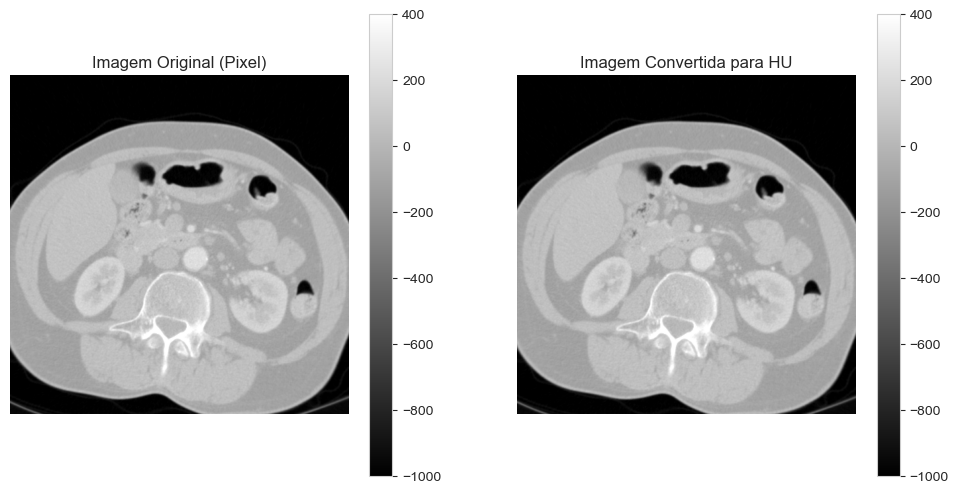

In [94]:
pixel_image = image.pixel_array

# Testar a função de conversão para HU
hu_image = to_hu(image.pixel_array)

# Visualizar as duas imagens lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Imagem original (pixels)
axes[0].imshow(pixel_image, cmap='gray')
axes[0].set_title('Imagem Original (Pixel)')

# Imagem convertida para HU
axes[1].imshow(hu_image, cmap='gray')
axes[1].set_title('Imagem Convertida para HU')

# Mostrar as barras de cor
for ax in axes:
    ax.axis('off')
    plt.colorbar(ax.imshow(hu_image, cmap='gray'), ax=ax)

plt.show()

Como é possível observar, não há diferença visual significativa entre as duas imagens , o que é esperado e desejável, pois o objetivo da conversão para Hounsfield Units (HU) não é alterar a aparência visual, mas sim recalibrar os valores numéricos dos píxeis.

Ao inspecionar o array resultante, verifica-se que os valores agora correspondem a densidades físicas reais, refletindo com maior precisão os diferentes materiais anatómicos (como ar, tecidos e osso).

- Após confirmar visualmente que não há alterações perceptíveis nas imagens, analisamos agora os valores numéricos dos píxeis antes e depois da conversão para Hounsfield Units.

- Esta comparação permite verificar que a função `to_hu()` reescala corretamente os valores originais , que estavam em unidades arbitrárias ,para o intervalo físico padrão dos Hounsfield Units (aproximadamente de -1000 a 400), garantindo que cada voxel representa de forma fiel a densidade do tecido.

In [72]:
print(pixel_image)

[[29 29 25 ...  9 18 27]
 [34 36 31 ... 18 28 23]
 [34 40 33 ... 22 24 23]
 ...
 [87 78 73 ... 66 55 52]
 [86 70 71 ... 80 63 63]
 [77 65 73 ... 84 73 73]]


In [73]:
print(hu_image)

[[ -995  -995  -999 ... -1000 -1000  -997]
 [ -990  -988  -993 ... -1000  -996 -1000]
 [ -990  -984  -991 ... -1000 -1000 -1000]
 ...
 [ -937  -946  -951 ...  -958  -969  -972]
 [ -938  -954  -953 ...  -944  -961  -961]
 [ -947  -959  -951 ...  -940  -951  -951]]


Os valores agora seguem a escala de HU, onde valores mais baixos representam ar e valores mais altos correspondem a estruturas ósseas.

#### Normalização

- Após a conversão para Hounsfield Units, normalizamos os valores de intensidade para o intervalo [0, 1].

- Este passo assegura que todas as imagens têm a mesma escala numérica, essencial para o treino de modelos de deep learning.


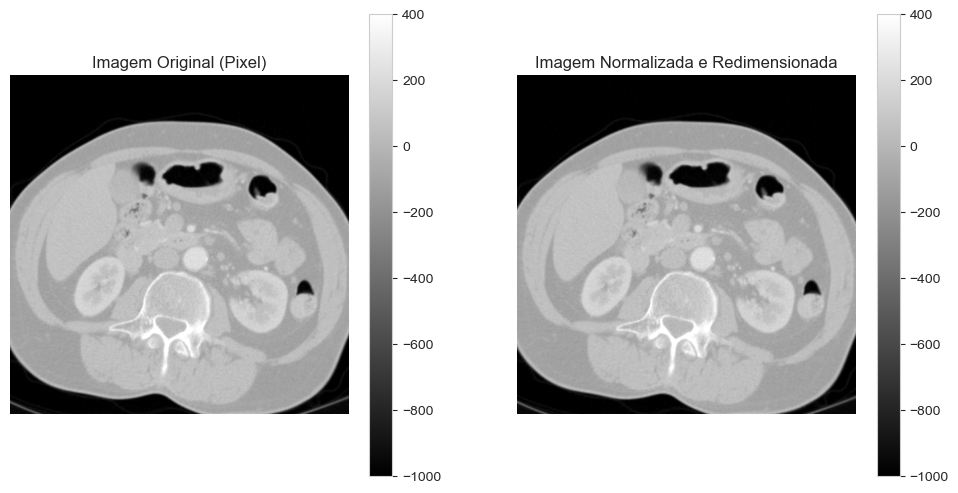

In [74]:
normalized_image = norm(hu_image)

# Visualizar as duas imagens lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Imagem original (pixels)
axes[0].imshow(pixel_image, cmap='gray')
axes[0].set_title('Imagem Original (Pixel)')

# Imagem convertida para HU
axes[1].imshow(normalized_image, cmap='gray')
axes[1].set_title('Imagem Normalizada e Redimensionada')

# Mostrar as barras de cor
for ax in axes:
    ax.axis('off')
    plt.colorbar(ax.imshow(hu_image, cmap='gray'), ax=ax)

plt.show()

Observa-se que, apesar da normalização alterar a escala dos valores de intensidade, o aspeto visual da imagem permanece praticamente idêntico , indicando que a informação anatómica foi preservada e que as imagens estão agora prontas para serem processadas de forma consistente.

- Para analisar numericamente o efeito da normalização, é possível observar a distribuição dos valores de intensidade através dos histogramas antes e depois do processo.

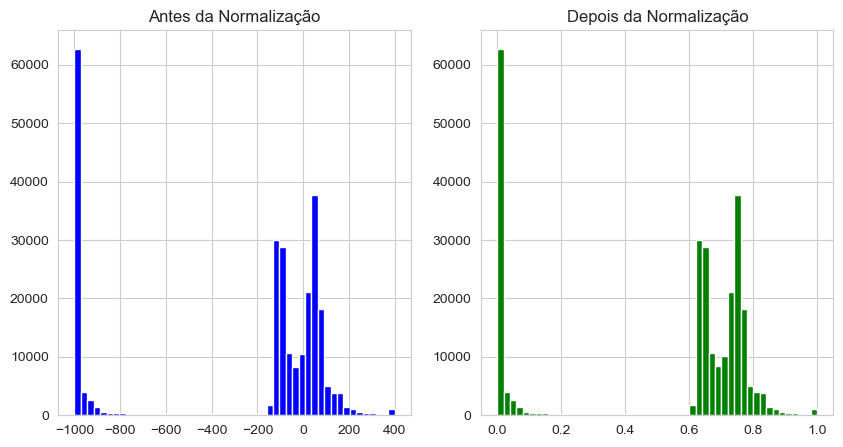

In [75]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(hu_image.flatten(), bins=50, color='blue')
plt.title('Antes da Normalização')

plt.subplot(1, 2, 2)
plt.hist(normalized_image.flatten(), bins=50, color='green')
plt.title('Depois da Normalização')

plt.show()

Conclui-se que a normalização não altera a forma da distribuição dos valores, apenas os reescala para o intervalo [0, 1]. Desta forma, preserva-se a informação estrutural da imagem, garantindo simultaneamente consistência entre diferentes amostras.

- Para visualizar a região anotada, foi gerada a máscara binária correspondente ao nódulo e sobreposta à imagem original, permitindo observar o seu contorno exato.

Loading dicom files ... This may take a moment.


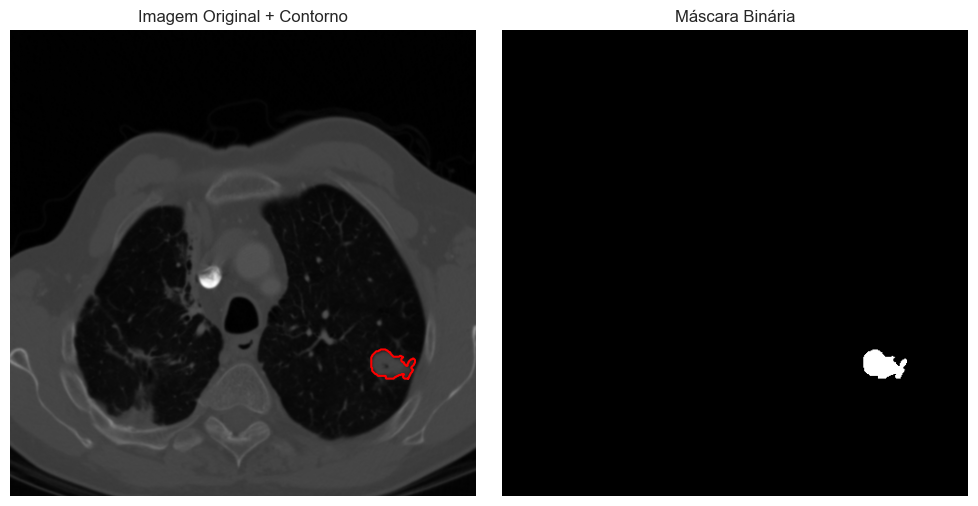

In [76]:
image, mask = seg2d(scan, annotation)

contours = measure.find_contours(mask, level=0.5)

# Plot for 2 images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left
axes[0].imshow(image, cmap='gray')
for contour in contours:
    axes[0].plot(contour[:, 1], contour[:, 0], color='red', linewidth=1.5)
axes[0].set_title('Imagem Original + Contorno')
axes[0].axis('off')

# Right
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Máscara Binária')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Na imagem da esquerda, o contorno vermelho destaca o nódulo identificado pelo especialista, enquanto a imagem da direita mostra a máscara binária usada para o segmentar. Esta máscara representa apenas a região de interesse (valor 1), sendo essencial para extrair características radiómicas de forma precisa.

- Para uma visualização espacial completa do nódulo, foi criada uma reconstrução tridimensional da máscara binária, permitindo observar o seu volume e forma no espaço 3D.

Loading dicom files ... This may take a moment.


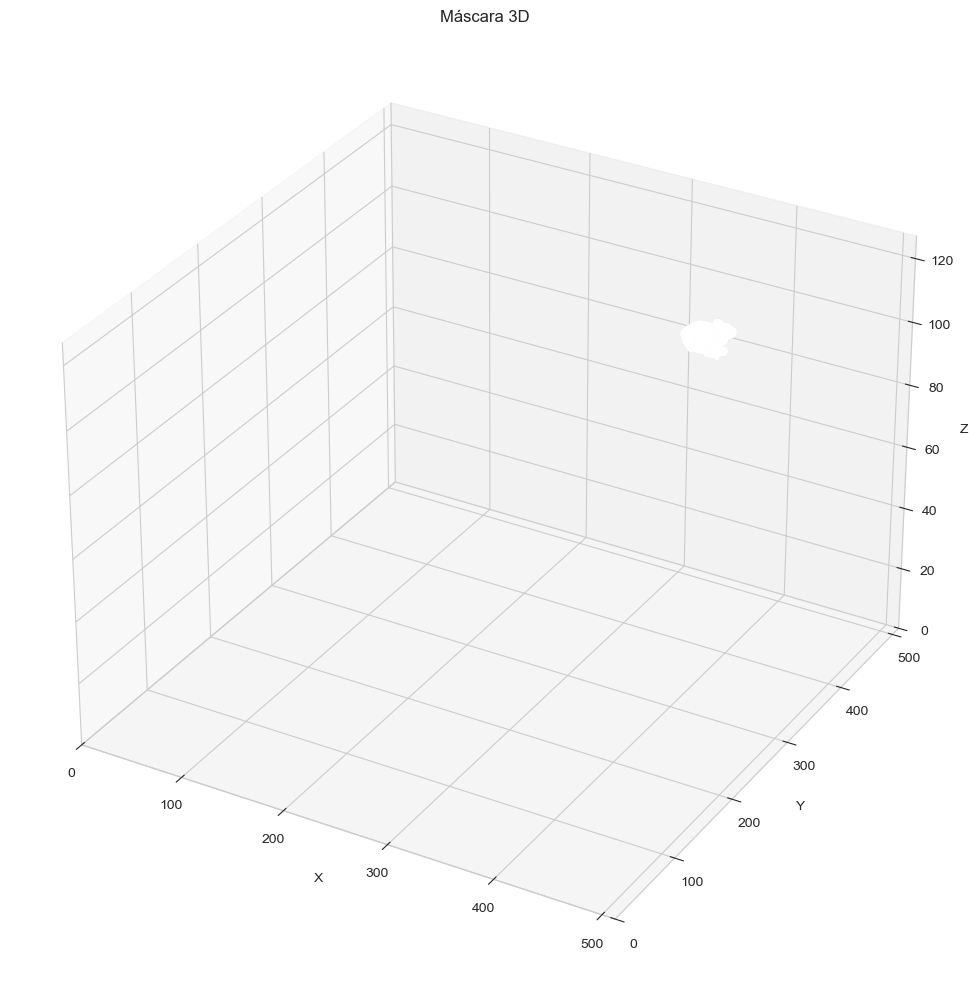

In [77]:
volume,mask = seg3d(scan, annotation)
verts, faces, _, _ = measure.marching_cubes(mask, level=0)

# --- Prepare mesh for Matplotlib ---
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a collection of triangles
mesh = Poly3DCollection(verts[faces], alpha=0.6)
mesh.set_facecolor('red')

# Add to the axes
ax.add_collection3d(mesh)

# Auto scale to the mesh size
ax.set_xlim(0, mask.shape[0])
ax.set_ylim(0, mask.shape[1])
ax.set_zlim(0, mask.shape[2])

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Máscara 3D")

plt.tight_layout()
plt.show()

A visualização 3D evidencia de forma clara o volume e a forma real do nódulo pulmonar, permitindo observar a sua posição exata dentro do conjunto de cortes de TC. Esta reconstrução sólida confirma a qualidade da segmentação e facilita análises morfológicas mais precisas antes da extração de características radiómicas.

### 3.10 Pacientes e Nódulos a Analizar

- Nesta etapa, é criada uma lista estruturada que associa cada nódulo às suas respetivas anotações. Este processo garante que todas as observações relacionadas com o mesmo nódulo sejam corretamente agrupadas, permitindo um processamento consistente e controlado nas fases seguintes.

In [96]:
df = pd.read_csv('annotations.csv')
# Nodule/Annotation List
na_list = []

for nodule_id in df['NoduloID'].unique():
    # Get the subset of rows corresponding to this nodule
    subset = df[df['NoduloID'] == nodule_id]
    
    # Loop over each annotation for this nodule
    for annot_idx, row in enumerate(subset.itertuples(), start=1):
        na_list.append([nodule_id, annot_idx])

#### Extração de Features 2D

- Estamos interessados nas features First-Order, Texture e Shape, que descrevem as propriedades de intensidade, textura e forma dos nódulos.

In [97]:
extractor_2d = featureextractor.RadiomicsFeatureExtractor() 

extractor_2d.disableAllFeatures()

extractor_2d.enableFeatureClassByName('firstorder')   
extractor_2d.enableFeatureClassByName('glcm')         
extractor_2d.enableFeatureClassByName('glrlm')        
extractor_2d.enableFeatureClassByName('glszm')        
extractor_2d.enableFeatureClassByName('gldm')         
extractor_2d.enableFeatureClassByName('ngtdm')        
extractor_2d.enableFeatureClassByName('shape2D')

- De seguida, é definida uma função responsável por automatizar o processo de extração de Radiomic Features 2D para cada nódulo e respetiva anotação. Esta função percorre todas as combinações de paciente–nódulo–anotação, realiza a segmentação individual de cada caso e aplica o extrator configurado do pyradiomics para calcular as features selecionadas. O resultado é consolidado num único DataFrame, posteriormente exportado para um ficheiro .csv para análise e validação.

In [98]:
def extract(nodule_annot_list, extractor, verbose=False):
    feature_list = []
    for nodule_id_str, annotation_id in nodule_annot_list:
        patient_id = "LIDC-IDRI-" + nodule_id_str[:4]
        nodule_id = int(nodule_id_str[5:])
        if verbose:
            print(f"Processing Patient {patient_id}, Nodule {nodule_id}, Annotation {annotation_id}")
        
        # Get scans
        scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()
        if not scans:
            warnings.warn(f"No scans found for patient {patient_id}")
            continue
        
        for scan in scans:
            # Get all annotations (each annotation is from one radiologist)
            all_annotations = scan.annotations
            
            # Group annotations by nodule (cluster annotations that refer to the same nodule)
            nodules = scan.cluster_annotations()
            
            if nodule_id > len(nodules):
                warnings.warn(f"Nodule {nodule_id} not found for {patient_id}")
                continue
            
            # Get the specific nodule cluster (list of annotations for this nodule)
            nodule_annotations = nodules[nodule_id - 1]
            
            if annotation_id > len(nodule_annotations):
                warnings.warn(f"Annotation {annotation_id} not found for {nodule_id_str} (only {len(nodule_annotations)} annotations available)")
                continue
            
            # Get the SPECIFIC annotation (1-indexed)
            specific_annotation = nodule_annotations[annotation_id - 1]
            
            try:
                # Segment using the SPECIFIC annotation
                imagem, mascara = seg2d(scan, specific_annotation)
                
                # Convert to HU
                imagem_hu = to_hu(imagem)
                
                # Convert to SimpleITK
                imagem_sitk = sitk.GetImageFromArray(imagem_hu)
                mascara_sitk = sitk.GetImageFromArray(mascara.astype(np.uint8))
                
                # Extract features
                features = extractor.execute(imagem_sitk, mascara_sitk)
                feature_dict = dict(features)
                
                # Add IDs
                feature_dict['NoduloID'] = nodule_id_str
                feature_dict['Annotation_ID'] = annotation_id
                feature_list.append(feature_dict)
                
            except Exception as e:
                warnings.warn(f"Error processing {patient_id} Nodule {nodule_id} Annotation {annotation_id}: {e}")
    
    df_features = pd.DataFrame(feature_list)
    df_features.to_csv('radiomics_features_2d.csv', index=False, encoding='utf-8')
    return df_features

# Já corremos esta função COM output para ver que nada correu mal, fizemos desta forma para o notebook ficar mais apresentável.
#with silence_all_output():
#    df = extract(na_list, extractor_2d)

Esta função garante um fluxo totalmente reprodutível de extração de features, com tratamento automático de erros e registo dos identificadores de cada instância. O ficheiro final `radiomics_features_2d.csv` contém todas as features calculadas para cada nódulo e anotação.

#### Extração das Features 3D

- Após a extração das Radiomic Features 2D, procede-se à configuração do extrator 3D, que permite calcular as features a partir do volume completo do nódulo. Tal como anteriormente, são ativadas as classes First-Order, Texture (GLCM, GLRLM, GLSZM, GLDM, NGTDM) e Shape, esta última agora na sua versão tridimensional, permitindo caracterizar a geometria volumétrica do nódulo de forma mais completa.

In [99]:
extractor_3d = featureextractor.RadiomicsFeatureExtractor() 

extractor_3d.disableAllFeatures()

extractor_3d.enableFeatureClassByName('firstorder')   
extractor_3d.enableFeatureClassByName('glcm')         
extractor_3d.enableFeatureClassByName('glrlm')        
extractor_3d.enableFeatureClassByName('glszm')        
extractor_3d.enableFeatureClassByName('gldm')         
extractor_3d.enableFeatureClassByName('ngtdm')        
extractor_3d.enableFeatureClassByName('shape') # é em 3D

- É então definida uma função responsável pela extração automática das Radiomic Features 3D. Tal como na abordagem 2D, a função percorre cada combinação paciente–nódulo–anotação, segmenta o volume correspondente e aplica o extrator configurado. A diferença principal reside no facto de o cálculo ser efetuado sobre o volume tridimensional completo, permitindo capturar de forma mais fiel as propriedades espaciais, de textura e forma do nódulo.

In [100]:
def extract3d(nodule_annot_list, extractor, verbose=False):
    feature_list = []

    for nodule_id_str, annotation_id in nodule_annot_list:
        patient_id = "LIDC-IDRI-" + nodule_id_str[:4]
        nodule_id = int(nodule_id_str[5:])
        if verbose:
            print(f"Processing Patient {patient_id}, Nodule {nodule_id}, Annotation {annotation_id}")

        # Get scans
        scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()
        if not scans:
            warnings.warn(f"No scans found for patient {patient_id}")
            continue

        for scan in scans:
            # Group annotations by nodule
            nodules = scan.cluster_annotations()
            if nodule_id > len(nodules):
                warnings.warn(f"Nodule {nodule_id} not found for {patient_id}")
                continue

            # Get the specific nodule cluster (all radiologist annotations for this nodule)
            nodule_annotations = nodules[nodule_id - 1]
            if annotation_id > len(nodule_annotations):
                warnings.warn(f"Annotation {annotation_id} not found for {nodule_id_str} (only {len(nodule_annotations)} annotations available)")
                continue

            # Get the specific annotation
            specific_annotation = nodule_annotations[annotation_id - 1]

            try:
                volume, mask = seg3d(scan, specific_annotation)

                # Convert to HU (3D)
                volume_hu = to_hu(volume)

                # Convert to SimpleITK images
                volume_sitk = sitk.GetImageFromArray(volume_hu)
                mask_sitk = sitk.GetImageFromArray(mask.astype(np.uint8))

                # Extract 3D radiomics features
                features = extractor.execute(volume_sitk, mask_sitk)
                feature_dict = dict(features)

                # Add identifiers
                feature_dict['NoduloID'] = nodule_id_str
                feature_dict['Annotation_ID'] = annotation_id
                feature_list.append(feature_dict)

            except Exception as e:
                warnings.warn(f"Error processing {patient_id} Nodule {nodule_id} Annotation {annotation_id}: {e}")

    # Convert to DataFrame and save
    df_features = pd.DataFrame(feature_list)
    df_features.to_csv('radiomics_features_3d.csv', index=False, encoding='utf-8')
    return df_features

# Já corremos esta função COM output para ver que nada correu mal, fizemos desta forma para o notebook ficar mais apresentável.
#with silence_all_output():
#    df = extract3d(na_list, extractor_3d)

Esta função consolida todas as features tridimensionais extraídas num único ficheiro (`radiomics_features_3d.csv`), garantindo um pipeline uniforme entre as abordagens 2D e 3D.

## parte da chica 

### References
[^1]: https://www.sciencedirect.com/science/article/abs/pii/S1566253516301063


Sabemos que os 3 datasets têm NoduleID e Annotation_ID por isso vamos fazer merge consuante essas duas colunas. O objetivo é obter um dataset com  17+126-131-2-1 = 271 colunas.

In [83]:
df2d = pd.read_csv("radiomics_features_2d.csv")
df3d = pd.read_csv("radiomics_features_3d.csv")
df_ann = pd.read_csv("annotations.csv")

Primeiro passo é confirmarmos a presença das duas colunas.

In [84]:
datasets = {
    "2D Features": df2d,
    "3D Features": df3d,
    "Annotations": df_ann
}

required_cols = ["NoduloID", "Annotation_ID"]

for name, df in datasets.items():
    print(f"\n Dataset: {name}")
    for col in required_cols:
        if col in df.columns:
            print(f"Has column: {col}")
        else:
            print(f"Doesn't have column: {col}")
    print(f"Total number of columns: {len(df.columns)}")


 Dataset: 2D Features
Has column: NoduloID
Has column: Annotation_ID
Total number of columns: 126

 Dataset: 3D Features
Has column: NoduloID
Has column: Annotation_ID
Total number of columns: 131

 Dataset: Annotations
Has column: NoduloID
Doesn't have column: Annotation_ID
Total number of columns: 17


Como podemos ver o dataset ```annotations.csv``` não tem a coluna Annotation_ID, mas sim Annotation ID. Por isso vamos mudar o nome da coluna para facilitar o merge.

In [85]:
df_ann.rename(columns={"Annotation ID": "Annotation_ID"}, inplace=True)

print("Annotation_ID" in df_ann.columns)

False


Vamos confirmar que os 3 datasets têm o mesmo numero de linhas e que as colunas NoduloID têm os mesmos valores.

In [86]:
ids_2d = set(df2d["NoduloID"])
ids_3d = set(df3d["NoduloID"])
ids_ann = set(df_ann["NoduloID"])

print("IDs present across all datasets:", len(ids_2d & ids_3d & ids_ann))
print("IDs only in 2D:", len(ids_2d - ids_3d - ids_ann))
print("IDs only in 3D:", len(ids_3d - ids_2d - ids_ann))
print("IDs only in Annotations:", len(ids_ann - ids_2d - ids_3d))

IDs present across all datasets: 1164
IDs only in 2D: 0
IDs only in 3D: 0
IDs only in Annotations: 0


Vamos então fazer o merge dos 3 datasets, com o objetivo de obter um dataset com dados tanto de anotações como de features 2d e 3d. Este dataset vai estar por anotação, ou seja, cada linha corresponde a uma anotação diferente. Este não é o objetivo final, visto que vamos treinar o modelo por nódulo e não por anotação.

In [87]:
df_merged = df_ann.merge(df2d, on=["NoduloID", "Annotation_ID"]) \
                    .merge(df3d, on=["NoduloID", "Annotation_ID"])

KeyError: 'Annotation_ID'

In [ ]:
pd.set_option('display.max_columns', None)
df_merged.head()

,NoduloID,Annotation_ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,diagnostics_Versions_PyRadiomics_x,diagnostics_Versions_Numpy_x,diagnostics_Versions_SimpleITK_x,diagnostics_Versions_PyWavelet_x,diagnostics_Versions_Python_x,diagnostics_Configuration_Settings_x,diagnostics_Configuration_EnabledImageTypes_x,diagnostics_Image-original_Hash_x,diagnostics_Image-original_Dimensionality_x,diagnostics_Image-original_Spacing_x,diagnostics_Image-original_Size_x,diagnostics_Image-original_Mean_x,diagnostics_Image-original_Minimum_x,diagnostics_Image-original_Maximum_x,diagnostics_Mask-original_Hash_x,diagnostics_Mask-original_Spacing_x,diagnostics_Mask-original_Size_x,diagnostics_Mask-original_BoundingBox_x,diagnostics_Mask-original_VoxelNum_x,diagnostics_Mask-original_VolumeNum_x,diagnostics_Mask-original_CenterOfMassIndex_x,diagnostics_Mask-original_CenterOfMass_x,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_TotalEnergy_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_

In [ ]:
df_merged.shape[1]

271

Antes de aplicar qualquer processo de agregação ou modelagem, é fundamental realizar uma análise exploratória e limpeza do dataset, de forma a eliminar redundâncias e variáveis sem utilidade estatística.

Primeiro vamos verificar a existência de valores nulos.

In [ ]:
null_counts = df_merged.isna().sum()
print("Number of null values per column:")
print(null_counts[null_counts > 0])

if df_merged.isnull().values.any():
    print("\nThere are null values in the dataset.")
else:
    print("\nNo null values where found in the dataset.")

Number of null values per column:
Series([], dtype: int64)

No null values where found in the dataset.


Vamos agora identificar e remover colunas com valor único uma vez que estas não são relevantes para distinguir nódulos uns dos outros.

In [ ]:
unique_counts = df_merged.nunique()
cols_unique = unique_counts[unique_counts == 1].index.tolist()

print(f"\n Columns with unique value({len(cols_unique)}):")
print(cols_unique)

df_merged.drop(columns=cols_unique, inplace=True)


 Columns with unique value(24):
['diagnostics_Versions_PyRadiomics_x', 'diagnostics_Versions_Numpy_x', 'diagnostics_Versions_SimpleITK_x', 'diagnostics_Versions_PyWavelet_x', 'diagnostics_Versions_Python_x', 'diagnostics_Configuration_Settings_x', 'diagnostics_Configuration_EnabledImageTypes_x', 'diagnostics_Image-original_Dimensionality_x', 'diagnostics_Image-original_Spacing_x', 'diagnostics_Image-original_Size_x', 'diagnostics_Image-original_Minimum_x', 'diagnostics_Mask-original_Spacing_x', 'diagnostics_Mask-original_Size_x', 'diagnostics_Versions_PyRadiomics_y', 'diagnostics_Versions_Numpy_y', 'diagnostics_Versions_SimpleITK_y', 'diagnostics_Versions_PyWavelet_y', 'diagnostics_Versions_Python_y', 'diagnostics_Configuration_Settings_y', 'diagnostics_Configuration_EnabledImageTypes_y', 'diagnostics_Image-original_Dimensionality_y', 'diagnostics_Image-original_Spacing_y', 'diagnostics_Image-original_Minimum_y', 'diagnostics_Mask-original_Spacing_y']


In [ ]:
df_merged.columns.tolist()

['NoduloID',
 'Annotation_ID',
 'Num Annotations',
 'Malignancy',
 'Calcification',
 'Internal Structure',
 'Spiculation',
 'Margin',
 'Subtlety',
 'Lobulation',
 'Texture',
 'Sphericity',
 'Volume',
 'Slice Thickness (mm)',
 'Pixel Resolution',
 'Number of Nodules',
 'Nodules >=3mm',
 'Nodules <3mm',
 'diagnostics_Image-original_Hash_x',
 'diagnostics_Image-original_Mean_x',
 'diagnostics_Image-original_Maximum_x',
 'diagnostics_Mask-original_Hash_x',
 'diagnostics_Mask-original_BoundingBox_x',
 'diagnostics_Mask-original_VoxelNum_x',
 'diagnostics_Mask-original_VolumeNum_x',
 'diagnostics_Mask-original_CenterOfMassIndex_x',
 'diagnostics_Mask-original_CenterOfMass_x',
 'original_shape2D_Elongation',
 'original_shape2D_MajorAxisLength',
 'original_shape2D_MaximumDiameter',
 'original_shape2D_MeshSurface',
 'original_shape2D_MinorAxisLength',
 'original_shape2D_Perimeter',
 'original_shape2D_PerimeterSurfaceRatio',
 'original_shape2D_PixelSurface',
 'original_shape2D_Sphericity',
 'ori

Uma vez que usamos PyRadiomics para obter algumas features, acabamos por ter colunas que são metadados técnicos, hashes ou informações fixas, que não descrevem o nódulo, mas sim o processo de geração da feature. Essas podem ser removidas.

In [ ]:
irrelevant_columns = [
    # --- Image metadata ---
    'diagnostics_Image-original_Hash_x',
    'diagnostics_Image-original_Mean_x',
    'diagnostics_Image-original_Maximum_x',
    'diagnostics_Image-original_Hash_y',
    'diagnostics_Image-original_Size_y',
    'diagnostics_Image-original_Mean_y',
    'diagnostics_Image-original_Maximum_y',

    # --- Mask metadata ---
    'diagnostics_Mask-original_Hash_x',
    'diagnostics_Mask-original_Size_x',
    'diagnostics_Mask-original_BoundingBox_x',
    'diagnostics_Mask-original_VoxelNum_x',
    'diagnostics_Mask-original_VolumeNum_x',
    'diagnostics_Mask-original_CenterOfMassIndex_x',
    'diagnostics_Mask-original_CenterOfMass_x',
    'diagnostics_Mask-original_Hash_y',
    'diagnostics_Mask-original_Size_y',
    'diagnostics_Mask-original_BoundingBox_y',
    'diagnostics_Mask-original_VoxelNum_y',
    'diagnostics_Mask-original_VolumeNum_y',
    'diagnostics_Mask-original_CenterOfMassIndex_y',
    'diagnostics_Mask-original_CenterOfMass_y'
]

In [ ]:
df_merged.drop(columns=irrelevant_columns, inplace=True, errors="ignore")

# Confirm the change
print(f"Removed {len(irrelevant_columns)} irrelevant columns (if present).")
print(f"Remaining columns: {df_merged.shape[1]}")

Removed 21 irrelevant columns (if present).
Remaining columns: 227


O terceiro passo é detetar se temos colunas duplicadas em termos de conteúdo, o que é muito comum por termos feito um merge de features 2D e 3D.

In [ ]:
# Check for duplicate columns
duplicate_cols = []
cols = df_merged.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if df_merged[cols[i]].equals(df_merged[cols[j]]):
            duplicate_cols.append((cols[i], cols[j]))

print(f"Found {len(duplicate_cols)} duplicate columns.")
for pair in duplicate_cols:
    print(pair)

Found 2 duplicate columns.
('original_firstorder_Energy_x', 'original_firstorder_TotalEnergy_x')
('original_firstorder_Energy_y', 'original_firstorder_TotalEnergy_y')


Assim vamos apenas manter a primeira ocurrencia do par de colunas duplicadas.

In [ ]:
df_merged = df_merged.loc[:, ~df_merged.T.duplicated()]
print(f"Dataset without duplicate columns. Total: {df_merged.shape[1]} columns.")


Dataset without duplicate columns. Total: 225 columns.


Por fim, vamos ver que colunas têm tipo object e defenir se devemos: manter, remover ou converter o tipo.

In [ ]:
colunms_objetc = df_merged.select_dtypes(include=['object']).columns.tolist()
print("\nColunms with type object:", colunms_objetc)


Colunms with type object: ['NoduloID']


Esta coluna, NodoloID, vai sempre ser type object como era de esperar então mantemos.

Agora queremos que as linhas do dataset passem a ser por nódulos e não por anotação, o que implica uma estratégia de agregação. Mas antes devemos confirmar se existe algum nódulo com apenas uma anotação, visto que estes não terão de ser alterados.

In [ ]:
counts = df_merged.groupby("NoduloID").size()

print(counts.value_counts().sort_index())

1    417
2    138
3    216
4    393
Name: count, dtype: int64


In [ ]:
pd.set_option('display.max_columns', None)
df_merged.head()

,NoduloID,Annotation_ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_gldm_DependenceVariance_x,original_gldm_GrayLevelNonUniformity_x,original_gldm_GrayLevelVariance_x,original_gldm_HighGrayLevelEmphasis_x,original_gldm_LargeDependenceEmphasis_x,original_gldm_LargeDependenceHighGrayLevelEmphasis_x,original_gldm_LargeDependenceLowGrayLevelEmphasis_x,original_gldm_LowGrayLevelEmphasis_x,original_gldm_SmallDependenceEmphasis_x,original_gldm_SmallDependenceHighGrayLevelEmphasis_x,original_gldm_SmallDependenceLowGrayLevelEmphasis_x,original_ngtdm_Busyness_x,original_ngtdm_Coarseness_x,original_ngtdm_Complexity_x,original_ngtdm_Contrast_x,original_ngtdm_Strength_x,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_

Separamos em dois dataframes para aplicar a agragção apenas ao df_multi.

In [ ]:
nodule_single = counts[counts == 1].index
nodule_multi = counts[counts > 1].index

df_single = df_merged[df_merged["NoduloID"].isin(nodule_single)].copy()
df_multi = df_merged[df_merged["NoduloID"].isin(nodule_multi)].copy()

print(f"Nodules with a single annotation: {df_single['NoduloID'].nunique()}")
print(f"Nodules with various annotations: {df_multi['NoduloID'].nunique()}")

Nodules with a single annotation: 417
Nodules with various annotations: 747


In [ ]:
df_single.head()

,NoduloID,Annotation_ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_gldm_DependenceVariance_x,original_gldm_GrayLevelNonUniformity_x,original_gldm_GrayLevelVariance_x,original_gldm_HighGrayLevelEmphasis_x,original_gldm_LargeDependenceEmphasis_x,original_gldm_LargeDependenceHighGrayLevelEmphasis_x,original_gldm_LargeDependenceLowGrayLevelEmphasis_x,original_gldm_LowGrayLevelEmphasis_x,original_gldm_SmallDependenceEmphasis_x,original_gldm_SmallDependenceHighGrayLevelEmphasis_x,original_gldm_SmallDependenceLowGrayLevelEmphasis_x,original_ngtdm_Busyness_x,original_ngtdm_Coarseness_x,original_ngtdm_Complexity_x,original_ngtdm_Contrast_x,original_ngtdm_Strength_x,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_

In [ ]:
df_multi.head()

,NoduloID,Annotation_ID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_gldm_DependenceVariance_x,original_gldm_GrayLevelNonUniformity_x,original_gldm_GrayLevelVariance_x,original_gldm_HighGrayLevelEmphasis_x,original_gldm_LargeDependenceEmphasis_x,original_gldm_LargeDependenceHighGrayLevelEmphasis_x,original_gldm_LargeDependenceLowGrayLevelEmphasis_x,original_gldm_LowGrayLevelEmphasis_x,original_gldm_SmallDependenceEmphasis_x,original_gldm_SmallDependenceHighGrayLevelEmphasis_x,original_gldm_SmallDependenceLowGrayLevelEmphasis_x,original_ngtdm_Busyness_x,original_ngtdm_Coarseness_x,original_ngtdm_Complexity_x,original_ngtdm_Contrast_x,original_ngtdm_Strength_x,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_

### Justificação da Agregação de Anotações

Devido à **variabilidade entre radiologistas** nas avaliações clínicas (ex.: *malignidade*, *margem*, *espiculação*), o dataset foi convertido do **nível de anotação para o nível de nódulo**, de forma a obter uma única representação consolidada por nódulo.

Para variáveis **categóricas**, utilizou-se a **moda** (valor mais frequente).Para variáveis **numéricas contínuas**, adotou-se a **média aritmética** das anotações, conforme práticas estabelecidas em radiômica, onde a média é amplamente usada para representar o valor global de um nódulo.

Esta estratégia é suportada por estudos como **Chang et al. (2020)**, que demonstraram a eficácia da média em tarefas de agregação de múltiplas medições tumorais, e **Fontaine et al. (2020)**, que destacam a média como método simples e interpretável de *feature aggregation*. Revisões recentes, como **Guzzo et al. (2023)**, reforçam o uso da média como base para métodos mais avançados de fusão, enquanto **Zhang et al. (2023)** justificam o recurso a estatísticas descritivas (média e moda) para consenso entre múltiplos anotadores.



**Referências:**

- Chang, E. et al. (2020). *Comparison of Radiomic Feature Aggregation Methods for Patients with Multiple Tumors*. *J. Digital Imaging*, PMC7654896.

- Fontaine, P. et al. (2020). *The importance of feature aggregation in radiomics: a head and neck cancer study*. *Scientific Reports*, 10(1), 18727. 

- Guzzo, A. et al. (2023). *Data and model aggregation for radiomics applications: Emerging trends and open challenges*. *Information Fusion*.  

- Zhang, L. et al. (2023). *Learning from Multiple Annotators for Medical Image Segmentation*. *Pattern Recognition*.

A estratégia que vamos usar é separar as variáveis ordinais, das numéricas e da label que é categórica. Para as variáveis ordinais vamos fazer a moda. Mas para as varáveis numéricas vamos fazer a média.

In [ ]:
categorical_vars = ["Malignancy"]
ordinal_vars = [
    "Calcification", "Internal Structure", "Spiculation", "Margin",
    "Subtlety", "Lobulation", "Texture", "Sphericity"
]

numerical_vars = [col for col in df_multi.columns 
                 if col not in ["NoduloID"] + categorical_vars + ordinal_vars]

Começamos por fazer a média dos valores numéricos. Justificar com papper.

In [ ]:
df_multi_mean = (
    df_multi.groupby("NoduloID")[numerical_vars]
    .mean()
    .reset_index()
)

print(f"df_multi_mean created with {len(df_multi_mean)} single nodules.")
df_multi_mean.head(3)

df_multi_mean created with 747 single nodules.


,NoduloID,Annotation_ID,Num Annotations,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_gldm_DependenceVariance_x,original_gldm_GrayLevelNonUniformity_x,original_gldm_GrayLevelVariance_x,original_gldm_HighGrayLevelEmphasis_x,original_gldm_LargeDependenceEmphasis_x,original_gldm_LargeDependenceHighGrayLevelEmphasis_x,original_gldm_LargeDependenceLowGrayLevelEmphasis_x,original_gldm_LowGrayLevelEmphasis_x,original_gldm_SmallDependenceEmphasis_x,original_gldm_SmallDependenceHighGrayLevelEmphasis_x,original_gldm_SmallDependenceLowGrayLevelEmphasis_x,original_ngtdm_Busyness_x,original_ngtdm_Coarseness_x,original_ngtdm_Complexity_x,original_ngtdm_Contrast_x,original_ngtdm_Strength_x,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,o

Para os valores ordinais usamos a moda, mas temos de ter atenção aos casos de empate. Por isso vamos deixar estes de parte.

In [ ]:
ties = []
mode_results = []

for nid, group in df_multi.groupby("NoduloID"):
    result = {"NoduloID": nid}  
    
    for var in ordinal_vars:
        counts = group[var].value_counts(dropna=True)
        if counts.empty:
            result[var] = np.nan
            continue

        max_freq = counts.max()
        modes = counts[counts == max_freq].index.tolist()

        if len(modes) == 1:
            result[var] = modes[0]
        else:
            ties.append({"NoduloID": nid, "Feature": var, "Modes": modes})
            result[var] = np.nan 

    mode_results.append(result)

df_mode_ordinal = pd.DataFrame(mode_results)
df_ties = pd.DataFrame(ties)


In [ ]:
df_mode_ordinal.head(10)

,NoduloID,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity
0,0001-1,6.0,1.0,5.0,4.0,5.0,3.0,5.0,3.0
1,0002-1,6.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN
2,0003-2,6.0,1.0,2.0,3.0,5.0,2.0,4.0,4.0
3,0004-1,3.0,1.0,1.0,5.0,2.0,1.0,5.0,NaN
4,0007-1,6.0,1.0,5.0,3.0,5.0,NaN,5.0,4.0
5,0010-2,6.0,1.0,1.0,NaN,NaN,2.0,NaN,NaN
6,0011-10,6.0,1.0,5.0,NaN,NaN,1.0,5.0,3.0
7,0011-2,3.0,1.0,1.0,5.0,5.0,1.0,5.0,NaN
8,0011-5,6.0,1.0,1.0,5.0,NaN,1.0,5.0,NaN
9,0011-6,3.0,1.0,1.0,5.0,NaN,1.0,5.0,5.0


In [ ]:
df_ties.head(10) 

,NoduloID,Feature,Modes
0,0002-1,Margin,"[1, 2]"
1,0002-1,Subtlety,"[2, 1]"
2,0002-1,Texture,"[1, 2]"
3,0002-1,Sphericity,"[5, 3]"
4,0004-1,Sphericity,"[2, 5, 4, 3]"
5,0007-1,Lobulation,"[3, 4, 5, 1]"
6,0010-2,Margin,"[3, 5]"
7,0010-2,Subtlety,"[3, 5]"
8,0010-2,Texture,"[4, 5]"
9,0010-2,Sphericity,"[4, 2]"


Dado o elevado número de empates a estratégia que vamos adotar é escolher o valor maior, ou seja, uma abordagem mais severa.

Existem casos em que estamos entre 4 valores e não 2, será que escolher o maior e mais sevro faz sentido. REVER

In [ ]:
df_ties["Chosen"] = df_ties["Modes"].apply(lambda x: max(x))

In [ ]:
for _, row in df_ties.iterrows():
    nid = row["NoduloID"]
    feature = row["Feature"]
    chosen = row["Chosen"]
    # Substituir o valor da feature no df_mode_ordinal
    df_mode_ordinal.loc[df_mode_ordinal["NoduloID"] == nid, feature] = chosen

In [ ]:
df_mode_ordinal.head(10)

,NoduloID,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity
0,0001-1,6.0,1.0,5.0,4.0,5.0,3.0,5.0,3.0
1,0002-1,6.0,1.0,1.0,2.0,2.0,1.0,2.0,5.0
2,0003-2,6.0,1.0,2.0,3.0,5.0,2.0,4.0,4.0
3,0004-1,3.0,1.0,1.0,5.0,2.0,1.0,5.0,5.0
4,0007-1,6.0,1.0,5.0,3.0,5.0,5.0,5.0,4.0
5,0010-2,6.0,1.0,1.0,5.0,5.0,2.0,5.0,4.0
6,0011-10,6.0,1.0,5.0,4.0,5.0,1.0,5.0,3.0
7,0011-2,3.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0
8,0011-5,6.0,1.0,1.0,5.0,4.0,1.0,5.0,5.0
9,0011-6,3.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0


A última coluna que tem de ser colapsada é a label, Malignancy. Esperamos que esta tenha sempre o mesmo valor para um só nódulo, e que a passagem de anotações para nódulos seja direta.

In [ ]:
# Contar quantos valores únicos de "Malignancy" há por NoduloID
label_check = df_multi.groupby("NoduloID")["Malignancy"].nunique()

# Quantos nódulos têm sempre o mesmo valor
consistent = (label_check == 1).sum()

# Quantos têm valores contraditórios (problema)
inconsistent = (label_check > 1).sum()

print(f"Nodules with consistent label: {consistent}")
print(f"Nodules with inconsistent label: {inconsistent}")

Nodules with consistent label: 747
Nodules with inconsistent label: 0


In [ ]:
df_label = df_multi.groupby("NoduloID")["Malignancy"].first().reset_index()
df_label.head(10)

,NoduloID,Malignancy
0,0001-1,True
1,0002-1,True
2,0003-2,True
3,0004-1,False
4,0007-1,True
5,0010-2,False
6,0011-10,True
7,0011-2,False
8,0011-5,False
9,0011-6,False


In [ ]:
df_multi_collapsed = (
    df_mode_ordinal
    .merge(df_multi_mean, on="NoduloID", how="inner")
    .merge(df_label, on="NoduloID", how="inner")
)

print(f"df_multi_collapsed created with {df_multi_collapsed.shape[0]} nodules and {df_multi_collapsed.shape[1]} colunms.")
df_multi_collapsed.head(3)

df_multi_collapsed created with 747 nodules and 225 colunms.


,NoduloID,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Annotation_ID,Num Annotations,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_gldm_DependenceVariance_x,original_gldm_GrayLevelNonUniformity_x,original_gldm_GrayLevelVariance_x,original_gldm_HighGrayLevelEmphasis_x,original_gldm_LargeDependenceEmphasis_x,original_gldm_LargeDependenceHighGrayLevelEmphasis_x,original_gldm_LargeDependenceLowGrayLevelEmphasis_x,original_gldm_LowGrayLevelEmphasis_x,original_gldm_SmallDependenceEmphasis_x,original_gldm_SmallDependenceHighGrayLevelEmphasis_x,original_gldm_SmallDependenceLowGrayLevelEmphasis_x,original_ngtdm_Busyness_x,original_ngtdm_Coarseness_x,original_ngtdm_Complexity_x,original_ngtdm_Contrast_x,original_ngtdm_Strength_x,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDi

Agora que já temos o df_multi_collapsed, ou seja, por nódulo, vamos juntá-lo ao df_single e obtemos o dataset final.

In [ ]:
df_final = pd.concat([df_multi_collapsed, df_single], ignore_index=True)
print(f"Fianl dataset created {df_final.shape[0]} nodules and {df_final.shape[1]} colunms.")

Fianl dataset created 1164 nodules and 225 colunms.


In [ ]:
df_final.head(5)

,NoduloID,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Annotation_ID,Num Annotations,Volume,Slice Thickness (mm),Pixel Resolution,Number of Nodules,Nodules >=3mm,Nodules <3mm,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile_x,original_firstorder_90Percentile_x,original_firstorder_Energy_x,original_firstorder_Entropy_x,original_firstorder_InterquartileRange_x,original_firstorder_Kurtosis_x,original_firstorder_Maximum_x,original_firstorder_MeanAbsoluteDeviation_x,original_firstorder_Mean_x,original_firstorder_Median_x,original_firstorder_Minimum_x,original_firstorder_Range_x,original_firstorder_RobustMeanAbsoluteDeviation_x,original_firstorder_RootMeanSquared_x,original_firstorder_Skewness_x,original_firstorder_Uniformity_x,original_firstorder_Variance_x,original_glcm_Autocorrelation_x,original_glcm_ClusterProminence_x,original_glcm_ClusterShade_x,original_glcm_ClusterTendency_x,original_glcm_Contrast_x,original_glcm_Correlation_x,original_glcm_DifferenceAverage_x,original_glcm_DifferenceEntropy_x,original_glcm_DifferenceVariance_x,original_glcm_Id_x,original_glcm_Idm_x,original_glcm_Idmn_x,original_glcm_Idn_x,original_glcm_Imc1_x,original_glcm_Imc2_x,original_glcm_InverseVariance_x,original_glcm_JointAverage_x,original_glcm_JointEnergy_x,original_glcm_JointEntropy_x,original_glcm_MCC_x,original_glcm_MaximumProbability_x,original_glcm_SumAverage_x,original_glcm_SumEntropy_x,original_glcm_SumSquares_x,original_glrlm_GrayLevelNonUniformity_x,original_glrlm_GrayLevelNonUniformityNormalized_x,original_glrlm_GrayLevelVariance_x,original_glrlm_HighGrayLevelRunEmphasis_x,original_glrlm_LongRunEmphasis_x,original_glrlm_LongRunHighGrayLevelEmphasis_x,original_glrlm_LongRunLowGrayLevelEmphasis_x,original_glrlm_LowGrayLevelRunEmphasis_x,original_glrlm_RunEntropy_x,original_glrlm_RunLengthNonUniformity_x,original_glrlm_RunLengthNonUniformityNormalized_x,original_glrlm_RunPercentage_x,original_glrlm_RunVariance_x,original_glrlm_ShortRunEmphasis_x,original_glrlm_ShortRunHighGrayLevelEmphasis_x,original_glrlm_ShortRunLowGrayLevelEmphasis_x,original_glszm_GrayLevelNonUniformity_x,original_glszm_GrayLevelNonUniformityNormalized_x,original_glszm_GrayLevelVariance_x,original_glszm_HighGrayLevelZoneEmphasis_x,original_glszm_LargeAreaEmphasis_x,original_glszm_LargeAreaHighGrayLevelEmphasis_x,original_glszm_LargeAreaLowGrayLevelEmphasis_x,original_glszm_LowGrayLevelZoneEmphasis_x,original_glszm_SizeZoneNonUniformity_x,original_glszm_SizeZoneNonUniformityNormalized_x,original_glszm_SmallAreaEmphasis_x,original_glszm_SmallAreaHighGrayLevelEmphasis_x,original_glszm_SmallAreaLowGrayLevelEmphasis_x,original_glszm_ZoneEntropy_x,original_glszm_ZonePercentage_x,original_glszm_ZoneVariance_x,original_gldm_DependenceEntropy_x,original_gldm_DependenceNonUniformity_x,original_gldm_DependenceNonUniformityNormalized_x,original_gldm_DependenceVariance_x,original_gldm_GrayLevelNonUniformity_x,original_gldm_GrayLevelVariance_x,original_gldm_HighGrayLevelEmphasis_x,original_gldm_LargeDependenceEmphasis_x,original_gldm_LargeDependenceHighGrayLevelEmphasis_x,original_gldm_LargeDependenceLowGrayLevelEmphasis_x,original_gldm_LowGrayLevelEmphasis_x,original_gldm_SmallDependenceEmphasis_x,original_gldm_SmallDependenceHighGrayLevelEmphasis_x,original_gldm_SmallDependenceLowGrayLevelEmphasis_x,original_ngtdm_Busyness_x,original_ngtdm_Coarseness_x,original_ngtdm_Complexity_x,original_ngtdm_Contrast_x,original_ngtdm_Strength_x,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDi

In [ ]:
df_final.to_csv('final.csv', encoding='utf-8', index=False)

## Data Dictionary

### Dataset: `df_merge` (Merged Radiomics + Annotations)

Este dataset resulta da fusão dos ficheiros de anotações clínicas do **LIDC-IDRI** com as **features radiómicas extraídas (2D e 3D)** via PyRadiomics.  
Cada linha representa **um nódulo identificado e segmentado**, podendo existir várias anotações (radiologistas diferentes) para o mesmo nódulo.


### **1. Metadados e Variáveis Clínicas / Semânticas**

| Nome da Coluna | Tipo | Descrição | Exemplo | Notas |
|----------------|------|-----------|----------|-------|
| **NoduloID** | `string` | Identificador único do nódulo. | `0001-1` | Cada paciente pode ter vários nódulos. |
| **Annotation_ID** | `int` | ID da anotação associada ao nódulo. | `2` | Até 4 radiologistas por caso. |
| **Num Annotations** | `int` | Número de anotações disponíveis. | `4` | — |
| **Malignancy** | `bool` | Indica se o nódulo é maligno. | `True` | Calculado por média das classificações. |
| **Calcification** | `int` | Grau de calcificação (1–6). | `5` | — |
| **Internal Structure** | `int` | Estrutura interna do nódulo. | `2` | 1 = sólido, 2 = sub-sólido, etc. |
| **Spiculation** | `int` | Grau de espiculações. | `4` | — |
| **Margin** | `int` | Aspeto das margens. | `3` | — |
| **Subtlety** | `int` | Quão fácil é detetar o nódulo. | `5` | — |
| **Lobulation** | `int` | Grau de lobulação. | `3` | — |
| **Texture** | `int` | Textura visual avaliada. | `4` | — |
| **Sphericity** | `int` | Esfericidade subjetiva. | `4` | — |
| **Volume** | `float` | Volume do nódulo (mm³). | `7243.51` | Calculado a partir da segmentação 3D. |
| **Slice Thickness (mm)** | `float` | Espessura de corte do exame. | `2.5` | — |
| **Pixel Resolution** | `float` | Resolução espacial (mm²). | `0.703` | — |
| **Number of Nodules** | `int` | Nº total de nódulos no exame. | `3` | — |
| **Nodules ≥3mm** | `int` | Nº de nódulos com diâmetro ≥3 mm. | `1` | — |
| **Nodules <3mm** | `int` | Nº de nódulos com diâmetro <3 mm. | `2` | — |



### **2. Radiomics – Shape 2D Features (`original_shape2D_*`)**

Descrevem a forma do nódulo numa **fatia bidimensional** (2D).

| Nome da Coluna | Tipo | Exemplo | Descrição |
|----------------|------|----------|------------|
| `original_shape2D_Elongation` | `float` | `0.82` | Alongamento do objeto (razão de eixos). |
| `original_shape2D_MajorAxisLength` | `float` | `44.73` | Comprimento do eixo maior. |
| `original_shape2D_MinorAxisLength` | `float` | `36.22` | Comprimento do eixo menor. |
| `original_shape2D_MaximumDiameter` | `float` | `47.15` | Maior diâmetro 2D. |
| `original_shape2D_MeshSurface` | `float` | `1086.40` | Área 2D da malha do nódulo. |
| `original_shape2D_Perimeter` | `float` | `170.62` | Perímetro da forma 2D. |
| `original_shape2D_PixelSurface` | `float` | `1089.32` | Área em pixels. |
| `original_shape2D_Sphericity` | `float` | `0.68` | Quão próximo de circular é o nódulo. |
| `original_shape2D_PerimeterSurfaceRatio` | `float` | `0.157` | Relação perímetro/área. |



### **3. Radiomics – First-Order Features (2D & 3D)**

Estatísticas simples sobre as intensidades dos voxels, sem considerar textura.

| Nome da Coluna | Tipo | Exemplo (2D / 3D) | Descrição |
|----------------|------|------------------|------------|
| `original_firstorder_Mean_x` / `_y` | `float` | `103.5 / 105.7` | Média de intensidades. |
| `original_firstorder_Median_x` / `_y` | `float` | `102.1 / 104.3` | Mediana das intensidades. |
| `original_firstorder_Entropy_x` / `_y` | `float` | `7.42 / 7.65` | Aleatoriedade da distribuição. |
| `original_firstorder_Energy_x` / `_y` | `float` | `125.3 / 130.6` | Soma dos quadrados das intensidades. |
| `original_firstorder_Skewness_x` / `_y` | `float` | `-0.28 / -0.31` | Assimetria da distribuição. |
| `original_firstorder_Kurtosis_x` / `_y` | `float` | `3.14 / 3.25` | Achatamento da distribuição. |
| `original_firstorder_Minimum_x` / `_y` | `float` | `-956.0 / -954.5` | Valor mínimo. |
| `original_firstorder_Maximum_x` / `_y` | `float` | `124.5 / 128.2` | Valor máximo. |
| `original_firstorder_Range_x` / `_y` | `float` | `1080.5 / 1082.7` | Amplitude das intensidades. |



### **4. Radiomics – GLCM (Gray Level Co-occurrence Matrix)**

Mede a relação entre tons de cinzento adjacentes (textura de segunda ordem).

| Nome da Coluna | Tipo | Exemplo (2D / 3D) | Descrição |
|----------------|------|------------------|------------|
| `original_glcm_Contrast_x` / `_y` | `float` | `1.24 / 1.18` | Diferença de intensidade entre vizinhos. |
| `original_glcm_Correlation_x` / `_y` | `float` | `0.89 / 0.91` | Correlação linear entre tons. |
| `original_glcm_Energy_x` / `_y` | `float` | `0.015 / 0.014` | Energia da coocorrência. |
| `original_glcm_Homogeneity_x` / `_y` | `float` | `0.62 / 0.65` | Uniformidade local. |
| `original_glcm_Entropy_x` / `_y` | `float` | `7.58 / 7.60` | Entropia da matriz de coocorrência. |



### **5. Radiomics – GLRLM (Gray Level Run Length Matrix)**

Quantifica sequências (“runs”) de tons idênticos em linhas ou colunas.

| Nome da Coluna | Tipo | Exemplo (2D / 3D) | Descrição |
|----------------|------|------------------|------------|
| `original_glrlm_ShortRunEmphasis_x` / `_y` | `float` | `0.57 / 0.54` | Ênfase em runs curtos. |
| `original_glrlm_LongRunEmphasis_x` / `_y` | `float` | `2.31 / 2.45` | Ênfase em runs longos. |
| `original_glrlm_RunEntropy_x` / `_y` | `float` | `6.12 / 6.20` | Aleatoriedade de runs. |
| `original_glrlm_HighGrayLevelRunEmphasis_x` / `_y` | `float` | `930.5 / 945.2` | Ênfase em runs com tons altos. |
| `original_glrlm_RunPercentage_x` / `_y` | `float` | `0.75 / 0.72` | Densidade de runs. |



### **6. Radiomics – GLSZM (Gray Level Size Zone Matrix)**

Descreve a distribuição de **zonas** (áreas conectadas) de intensidade constante.

| Nome da Coluna | Tipo | Exemplo (2D / 3D) | Descrição |
|----------------|------|------------------|------------|
| `original_glszm_SmallAreaEmphasis_x` / `_y` | `float` | `0.68 / 0.70` | Ênfase em zonas pequenas. |
| `original_glszm_LargeAreaEmphasis_x` / `_y` | `float` | `4.42 / 4.55` | Ênfase em zonas grandes. |
| `original_glszm_ZoneEntropy_x` / `_y` | `float` | `6.84 / 6.92` | Aleatoriedade de zonas. |
| `original_glszm_GrayLevelVariance_x` / `_y` | `float` | `2.15 / 2.32` | Variância dos níveis cinzentos. |
| `original_glszm_SizeZoneNonUniformity_x` / `_y` | `float` | `102.3 / 110.7` | Não-uniformidade do tamanho das zonas. |



### **7. Radiomics – GLDM (Gray Level Dependence Matrix)**

Captura dependências locais entre voxels com intensidades semelhantes.

| Nome da Coluna | Tipo | Exemplo (2D / 3D) | Descrição |
|----------------|------|------------------|------------|
| `original_gldm_DependenceEntropy_x` / `_y` | `float` | `5.48 / 5.63` | Aleatoriedade das dependências. |
| `original_gldm_SmallDependenceEmphasis_x` / `_y` | `float` | `0.88 / 0.85` | Ênfase em pequenas dependências. |
| `original_gldm_LargeDependenceEmphasis_x` / `_y` | `float` | `2.41 / 2.33` | Ênfase em dependências grandes. |
| `original_gldm_HighGrayLevelEmphasis_x` / `_y` | `float` | `910.6 / 932.4` | Ênfase em níveis altos. |
| `original_gldm_GrayLevelNonUniformity_x` / `_y` | `float` | `102.1 / 108.9` | Não-uniformidade de níveis. |



###  **8. Radiomics – NGTDM (Neighborhood Gray Tone Difference Matrix)**

Avalia o contraste entre um voxel e a média dos seus vizinhos.

| Nome da Coluna | Tipo | Exemplo (2D / 3D) | Descrição |
|----------------|------|------------------|------------|
| `original_ngtdm_Coarseness_x` / `_y` | `float` | `0.022 / 0.025` | Granularidade da textura. |
| `original_ngtdm_Contrast_x` / `_y` | `float` | `11.52 / 12.18` | Diferença local de intensidade. |
| `original_ngtdm_Busyness_x` / `_y` | `float` | `125.3 / 131.4` | Variação rápida de tons. |
| `original_ngtdm_Complexity_x` / `_y` | `float` | `1240.5 / 1320.7` | Complexidade estrutural. |
| `original_ngtdm_Strength_x` / `_y` | `float` | `0.48 / 0.50` | Intensidade da estrutura tonal. |



###  **9. Radiomics – Shape 3D Features (`original_shape_*`)**

Descrevem a geometria tridimensional do nódulo.

| Nome da Coluna | Tipo | Exemplo | Descrição |
|----------------|------|----------|------------|
| `original_shape_Elongation` | `float` | `0.51` | Alongamento do volume. |
| `original_shape_Flatness` | `float` | `0.12` | Grau de achatamento. |
| `original_shape_LeastAxisLength` | `float` | `1.65` | Comprimento do menor eixo. |
| `original_shape_MajorAxisLength` | `float` | `35.59` | Comprimento do eixo principal. |
| `original_shape_MinorAxisLength` | `float` | `34.94` | Comprimento do eixo secundário. |
| `original_shape_Maximum3DDiameter` | `float` | `50.02` | Maior diâmetro 3D. |
| `original_shape_MeshVolume` | `float` | `6802.87` | Volume do nódulo (mm³). |
| `original_shape_SurfaceArea` | `float` | `3475.42` | Área da superfície (mm²). |
| `original_shape_SurfaceVolumeRatio` | `float` | `0.51` | Relação área/volume. |
| `original_shape_Sphericity` | `float` | `0.50` | Quão esférico é o nódulo. |
| `original_shape_VoxelVolume` | `float` | `6844.0` | Volume baseado em voxels. |
| `original_shape_Maximum2DDiameterSlice` | `float` | `40.01` | Maior diâmetro numa fatia 2D. |
| `original_shape_Maximum2DDiameterRow` | `float` | `49.01` | Maior diâmetro (linha). |
| `original_shape_Maximum2DDiameterColumn` | `float` | `50.01` | Maior diâmetro (coluna). |




Agora vamos passar aos passos básicos de pre-processamento de dados que devem ser aplicados antes de treinar o modelo.

Primeiro removemos as colunas identificadoras. E passamos a label de true/false para 0/1.

In [ ]:
X = df_final.drop(columns=["NoduloID", "Malignancy", "Annotation_ID", "Num Annotations"], errors="ignore")
y = df_final["Malignancy"].astype(int)  

E dividimos o dataset em conjunto de treino e teste. É impotante recordar que este passo tem de ser feito antes da feature selection e do treino de diferentes modelos. Caso contrário corremos o risco de ter data leakage ou comparações injustas.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

E no final desta fase vamos nromalizar os dados para permitir o seu uso nos futuros modelos.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

A base radiômica contém centenas de features extraídas automaticamente a partir das imagens médicas, muitas delas altamente correlacionadas entre si e potencialmente redundantes.
Usar todas estas variáveis num modelo de classificação pode causar overfitting, dificultar a interpretabilidade e aumentar o custo computacional. Por isso vamos passar à fase de feature selection.

O primero método que aplicamos é a regularização L1, um método que adiciona um termo de penalização proporcional ao valor absoluto dos coeficientes
da regressão logística (ideal para targets binários). Essa penalização força vários coeficientes a zero,
resultando na seleção automática das features mais relevantes para a classificação.

https://pmc.ncbi.nlm.nih.gov/articles/PMC6707437/?utm_source=chatgpt.com

In [ ]:
# Inicializar listas
selected_features_L1_001 = []
selected_features_L1_01 = []
selected_features_L1_1  = []

# Loop sobre os dois valores de C
for C_value in [0.01, 0.1, 1.0]:
    lasso = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        random_state=42,
        max_iter=5000,
        C=C_value
    )
    lasso.fit(X_train, y_train)

    # Coeficientes absolutos
    importance = pd.Series(np.abs(lasso.coef_[0]), index=X_train.columns)
    importance = importance.sort_values(ascending=False)

    # Features com coeficiente ≠ 0
    selected_features = importance[importance > 0].index.tolist()

    # Guardar nas listas corretas
    if C_value == 0.1:
        selected_features_L1_01 = selected_features
    elif C_value == 1.0:
        selected_features_L1_1 = selected_features
    elif C_value == 0.01:
        selected_features_L1_001 = selected_features

print(f"C=0.01 → {len(selected_features_L1_001)} features")
print(f"Features selected with C=0.1: \n{selected_features_L1_001}")
print(f"C=0.1 → {len(selected_features_L1_01)} features")
print(f"Features selected with C=0.1: \n{selected_features_L1_01}")
print(f"C=1.0 → {len(selected_features_L1_1)} features")
print(f"Features selected with C=1.0: \n{selected_features_L1_1}")


C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=0.01 → 40 features
Features selected with C=0.1: 
['original_glrlm_LongRunEmphasis_x', 'original_glszm_SizeZoneNonUniformity_y', 'original_ngtdm_Complexity_x', 'original_gldm_LargeDependenceHighGrayLevelEmphasis_y', 'original_firstorder_Range_x', 'original_gldm_LargeDependenceHighGrayLevelEmphasis_x', 'original_glrlm_RunLengthNonUniformity_y', 'original_firstorder_90Percentile_x', 'original_ngtdm_Complexity_y', 'original_firstorder_Range_y', 'original_gldm_GrayLevelNonUniformity_y', 'original_glrlm_GrayLevelNonUniformity_y', 'original_glcm_ClusterShade_y', 'original_firstorder_InterquartileRange_y', 'original_shape_VoxelVolume', 'original_gldm_LargeDependenceLowGrayLevelEmphasis_y', 'original_firstorder_Kurtosis_y', 'original_shape_MeshVolume', 'original_firstorder_Kurtosis_x', 'original_gldm_DependenceNonUniformity_y', 'Volume', 'original_firstorder_Maximum_x', 'original_firstorder_Variance_y', 'original_shape_SurfaceArea', 'original_firstorder_Maximum_y', 'original_glcm_ClusterProm

Assim, com um C = 0.1 foram selecionadas 55, ou seja, a regularização é mais rígida. Com C = 1.0 foram selecionadas 109, quase o dobro. Futuramente vamos comparar qual é a melhor estratégia.

Agora vamos usar o PCA como feature extraction. O PCA transforma as features originais em um novo conjunto de variáveis não correlacionadas, denominadas componentes principais, obtidas a partir da decomposição espectral da matriz de covariância dos dados.Nesta decomposição, os autovetores representam as direções dos novos eixos (componentes principais), enquanto os autovalores indicam a importância relativa de cada eixo, ou seja, a quantidade de variância explicada. Assim, as primeiras componentes concentram a maior parte da variabilidade total do dataset, permitindo uma representação mais compacta dos dados.

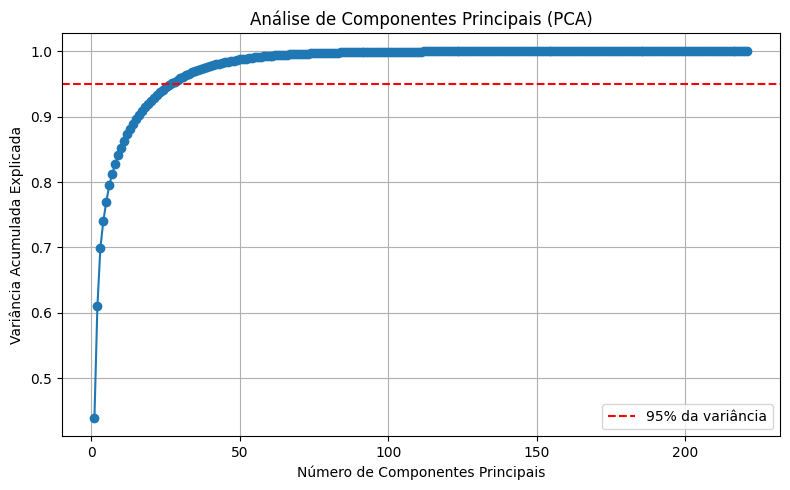


Número de componentes que explicam 95% da variância: 27
Dimensão original: 221, dimensão após PCA: 27


In [ ]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=None, random_state=42)
pca.fit(X_train_scaled)

# Variância explicada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Gráfico da variância explicada
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel("Número de Componentes Principais")
plt.ylabel("Variância Acumulada Explicada")
plt.title("Análise de Componentes Principais (PCA)")
plt.grid(True)
plt.axhline(0.95, color="red", linestyle="--", label="95% da variância")
plt.legend()
plt.tight_layout()
plt.show()

# Determinar quantos componentes mantêm 95% da variância
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
print(f"\nNúmero de componentes que explicam 95% da variância: {n_components_95}")

# Aplicar PCA com o número ótimo de componentes
pca_final = PCA(n_components=n_components_95, random_state=42)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca  = pca_final.transform(X_test_scaled)

print(f"Dimensão original: {X_train.shape[1]}, dimensão após PCA: {X_train_pca.shape[1]}")

In [ ]:
# Converter o resultado do PCA em DataFrame
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(n_components_95)])
X_test_pca_df  = pd.DataFrame(X_test_pca,  columns=[f"PC{i+1}" for i in range(n_components_95)])

# Visualizar as primeiras linhas
print("Head das novas features após PCA:")
display(X_train_pca_df.head())

Head das novas features após PCA:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
0,-6.979387,-5.911434,0.047749,1.968567,1.453961,0.310127,-0.387347,0.297951,1.216611,-0.786061,-0.641117,-1.603324,0.294948,-1.217696,1.517013,0.329660,-1.149492,-0.308714,-0.814757,0.221284,0.438449,0.151829,-0.000152,-0.342389,-0.242330,-0.188789,-0.281395
1,-5.905736,-3.428655,-0.600298,-0.003731,-1.271987,-0.166192,-0.185238,0.622862,1.670068,0.380857,-1.193446,-0.620739,2.008824,1.063225,-1.188690,-1.025196,-0.004766,2.147363,-1.385419,-0.822633,-0.781696,0.509190,-0.797713,0.310003,-1.263666,-0.510772,-1.010054
2,6.724722,-2.875351,-0.289746,-2.668378,0.032010,-1.915116,-1.935846,2.818973,-0.936399,0.568680,-1.029540,0.185406,3.899258,-1.993518,-1.799403,-0.398945,-0.196801,-1.310178,2.409607,0.089990,0.767349,-0.269937,1.296951,0.509465,-0.272939,-1.149190,-0.306240
3,-7.418089,-4.629968,1.455928,2.099278,0.268231,-0.834543,0.838820,-0.628821,-0.942162,-0.014574,-1.719781,-0.456304,-0.014359,-0.893467,0.583023,-0.602703,-0.000019,-0.673866,-0.697111,0.080282,0.406169,-0.336675,-0.430817,-0.534081,-0.068335,-0.550194,-0.096028
4,12.898412,-0.418333,-1.420864,-1.536209,0.272410,-1.400411,1.257923,-1.850389,-1.160334,-2.702514,-1.474955,1.743192,0.524950,-2.035874,-0.331309,0.077643,-0.465032,-0.234715,-0.197942,-0.143818,-0.218715,0.762516,0.206544,-0.020602,-0.485760,0.351180,-0.155577


A aplicação da Análise de Componentes Principais (PCA) reduziu significativamente a dimensionalidade do conjunto de dados radiômicos, passando de 221 features originais para apenas 27 componentes principais, que explicam 95% da variância total.
Isso demonstra que grande parte da informação contida nas features originais está concentrada em um pequeno subconjunto de combinações lineares, evidenciando alta redundância entre as variáveis radiômicas.
Assim, o PCA permite uma representação mais compacta e eficiente dos dados, reduzindo ruído e correlações redundantes, embora à custa de menor interpretabilidade clínica, já que os componentes principais são combinações matemáticas das features originais.

Dado que o dataset contém simultaneamente features radiômicas contínuas e variáveis clínicas ordinais (convertidas em escala 1–5/6), é possível aplicar o PCA tradicional, desde que todos os atributos sejam previamente normalizados.
As variáveis ordinais apresentam uma progressão monotónica coerente, o que justifica o seu tratamento como variáveis numéricas contínuas para efeito de decomposição linear.